In [81]:
library(SingleCellExperiment)
library(scater)
library(limma)
options(stringsAsFactors = FALSE)

In [82]:
# Set the raw data and save/load it
umi <- NULL
generateit = FALSE

if (is.null(umi) && generateit){
    counts_raw <- read.table("/extra/sebastian_arnolds/analysis/trim/counts_matrix.tsv",sep="\t")
    barcodes_vector <- as.vector(
        read.table("/extra/sebastian_arnolds/analysis/celseq_barcodes_raw_all.txt")[, 1]
    )
    count_matrix <- as.matrix(counts_raw[, barcodes_vector])

    # Change labels for genes of interest
    name_map = list(
        ENSMUSG00000062327 = "Brachyury",
        ENSMUSG00000032446 = "Eomes",
        ENSMUSG00000030544 = "Mesp1",
        ENSMUSG00000024406 = "Pou5f1",
        ENSMUSG00000012396 = "nanog",
        ENSMUSG00000096014 = "Sox1",
        ENSMUSG00000074637 = "Sox2",
        ENSMUSG00000090125 = "Pou3f1",
        ENSMUSG00000060206 = "zfp462",
        ENSMUSG00000031297 = "slc7a3"
    )

    for (i in 1:length(name_map)){
        old_gene_name <- names(name_map[i])
        new_gene_name <- name_map[[i]]
        #message(old_gene_name, "→", new_gene_name)
        rownames(count_matrix)[which(rownames(count_matrix) == old_gene_name)] <- new_gene_name
    }

    saveRDS(count_matrix, "seurat_matrix.rds")
    umi <- count_matrix

} else {
    umi <- as.matrix(readRDS("seurat_matrix.rds"))
}

In [83]:
# Create SCE and annotate
sce <- SingleCellExperiment(assays = list(counts = umi))
#head(counts(sce))

#sce <- getBMFeatureAnnos(
#    sce, 
#    filters = "ensembl_gene_id", 
#    attributes = c("ensembl_gene_id", "external_gene_name"), 
#    feature_symbol = "mgi_symbol",
#    feature_id = "ensembl_gene_id",
#    biomart = "ENSEMBL_MART_ENSEMBL",
#    dataset = "mmusculus_gene_ensembl", 
#    host = "www.ensembl.org"
#)

message(dim(sce)[1], " genes x ", dim(sce)[2], " cells. (", 
        length(unique(colnames(sce))), ") unique barcodes.")

21070 genes x 192 cells. (192) unique barcodes.


In [4]:
#head(counts_raw)
#message(dim(counts_prev), " → ", dim(counts_raw), " % ", 100*dim(counts_prev)/dim(counts_raw) )
#message(length(barcodes_prev), " → ", length(barcodes_vector), " % ", 100*length(barcodes_prev)/length(barcodes_vector))

In [15]:
# Check our matrix and our relabelled genes
#head(count_matrix)
#
#genes_of_interest <- !grepl("^ENS", rownames(count_matrix))
#goi_matrix <- count_matrix[genes_of_interest,]
#
#
#message(length(barcodes_vector), " barcodes → ", 
#        dim(count_matrix)[2], " cells")
#
#message(dim(count_matrix)[1], " genes → ", 
#       dim(goi_matrix)[1], " main genes of interest")

In [84]:
# Filter out any genes not found in any cell
gene_names_gt_zero <- rowSums(counts(sce) > 0) > 0

# apply
sce_f <- sce[gene_names_gt_zero,]

# Check to see if we lost our genes of interest
genes_of_interest <- !grepl("^ENS", rownames(sce_f))

message(length(sce), " genes → ", length(sce_f), " non-zero genes, \n(", 
        length(sce) - length(sce_f), " filtered out), (",
        length(sce_f[genes_of_interest,]), " genes of interest still remaining)"
        )

sce <- sce_f # reassign

21070 genes → 20662 non-zero genes, 
(408 filtered out), (9 genes of interest still remaining)


In [85]:
# Spike-ins used?
# 
non_ENS <- !grepl("^ENS", rownames(sce))
non_goi <- rownames(sce) %in% rownames(goi_matrix)

message("Spike-ins detected = ", length(rownames(sce[non_ENS && !non_goi,])))

ERROR: Error in rownames(goi_matrix): object 'goi_matrix' not found


In [88]:
# Assign known/related groups
is.meso <- rownames(sce) %in% c("Eomes", "Brachyury", "Mesp1")
is.pluri <- rownames(sce) %in% c("Pou5f1", "nanog")
is.neuro <- rownames(sce) %in% c("Sox1", "Sox2", "Pou3f1", "zfp462", "slc7a3")

rowData(sce)$is_mesoderm <- is.meso
rowData(sce)$is_pluripotenz <- is.pluri
rowData(sce)$is_neuroectoderm <- is.neuro

# Assign known/related cell batches
colData(sce)$plate_number <- c(rep("plate1", 96), rep("plate2", 96)) 
# XX: Ordering needs to be verified from source data.


List of length 1
names(1): counts

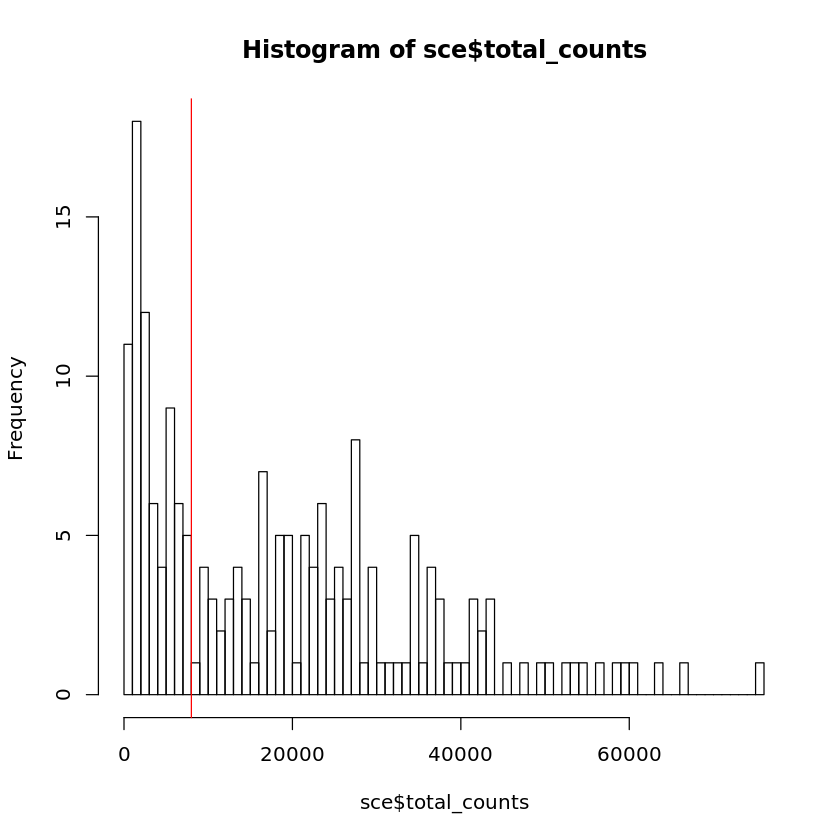

As shown, the counts follow a zero-inflated negative binomial distribution model due
to the genes that fail to be detected even through they are expressed ('dropouts')
For this we can apply ZINB-Wave later, which corrects for such distributions



FALSE  TRUE 
  121    71 

37% of cells contain less than 8000 counts


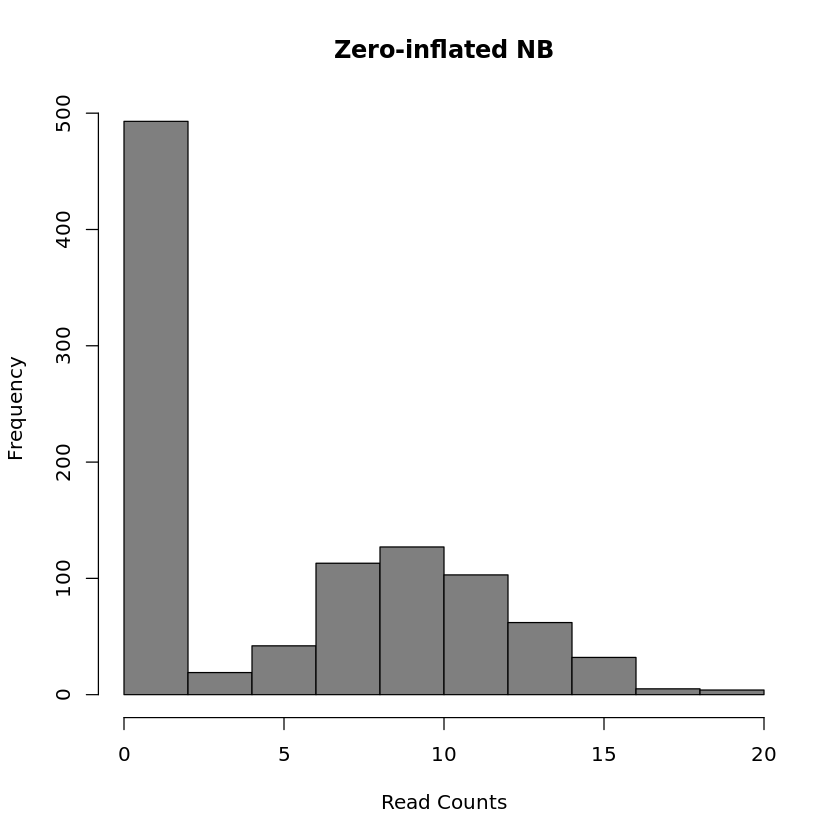

In [89]:
# Assign and calc some QC slots
sce <- calculateQCMetrics(sce)

assays(sce)

#names(colData(sce))
lc_thresh = 8000
hist(sce$total_counts, breaks=100)
abline(v=lc_thresh, col="red")

counts <- rnbinom(1000, mu = 10, size = 100)
counts[runif(1000) < 0.5] <- 0
hist(counts, col = "grey50", xlab = "Read Counts", main = "Zero-inflated NB")
message("As shown, the counts follow a zero-inflated negative binomial distribution model due
to the genes that fail to be detected even through they are expressed ('dropouts')")

message("For this we can apply ZINB-Wave later, which corrects for such distributions")


# !! 
# For now we will assume wells with low read-depth are of poor quality. We will likely
# return to this filtering step later if we cannot find any signal in the downstream analysis.
# !!
table(sce$total_counts <= lc_thresh)
perc <- 100  * sum(sce$total_counts <= lc_thresh) / length(sce$total_counts)

message(sprintf("%.0f%% of cells contain less than %.0f counts", perc, lc_thresh))


Most cells have between either 300-1700, or 5000-7000 detected genes

This is not related to the two different plates that the cells were loaded in, since the same profile is observed when using data from just one plate
(see: 2_postanal_lowres_singlebatch)


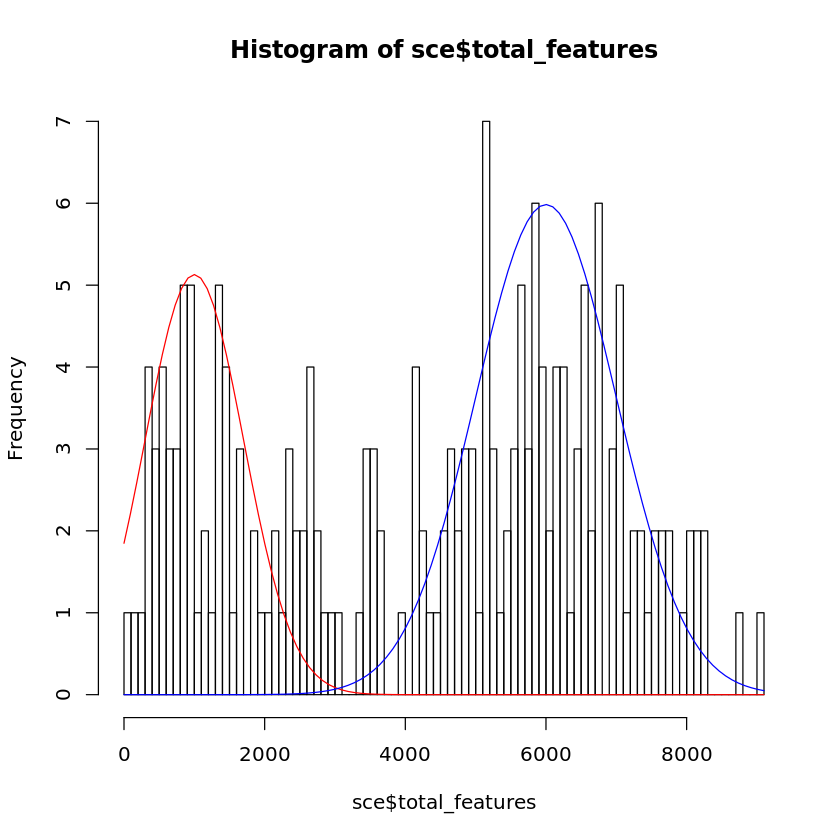

In [90]:
# Let us also assume 
hist(sce$total_features, breaks = 100)
curve(dnorm(x, 1000, 700) * 9000, col = "red", add = TRUE)
curve(dnorm(x, 6000, 1000) * 15000, col = "blue", add = TRUE)

message("Most cells have between either 300-1700, or 5000-7000 detected genes\n")
message("This is not related to the two different plates that the cells were loaded in, since the same profile is observed when using data from just one plate")
message("(see: 2_postanal_lowres_singlebatch)")



In [91]:
# Let us take a few metrics:
#    - "high_sequenced" - cells with counts above the low_count_threshold
#    - "low_sequenced" - cells with counts below or equal to the low_count_threshold
#    - "large_library" - cells with a large gene library (> 3000)
#    - "small_library" - cells with a small gene library (<= 3000)

gf_thresh = 3000

sce$high_sequenced <- (sce$total_counts > lc_thresh)
sce$low_sequenced <- (sce$total_counts <= lc_thresh)
sce$large_library <- (sce$total_features > gf_thresh)
sce$small_library <- (sce$total_features <= gf_thresh)

message("Num. cells with a high-seq depth = ", sum(sce$high_sequenced))
message("Num. cells with a low-seq depth = ", sum(sce$low_sequenced))
message("Num. cells with a large gene library = ", sum(sce$large_library))
message("Num. cells with a small gene library = ", sum(sce$small_library))
#message("")
#message("Num. cells with a high-seq depth + large gene library = ", sum(sce[sce$filter_welldef_lowgenes))
#message("Num. cells with a high selection of unique genes and high seq depth = ", sum(sce$filter_welldef_highgenes))

#dim(sce)
#dim(sce[sce$high_sequenced, sce$high_sequenced])

Num. cells with a high-seq depth = 121
Num. cells with a low-seq depth = 71
Num. cells with a large gene library = 123
Num. cells with a small gene library = 69


Here we confirm that plate number has no effect on the data
The following selected_variables were not found in colData(object): pct_counts_feature_controlsThe following selected_variables were not found in colData(object): total_features_feature_controlsThe following selected_variables were not found in colData(object): log10_total_counts_endogenousThe following selected_variables were not found in colData(object): log10_total_counts_feature_controls
Other variables from colData(object) can be used by specifying a vector of variable names as the selected_variables argument.
PCA is being conducted using the following variables:pct_counts_top_100_featurestotal_features


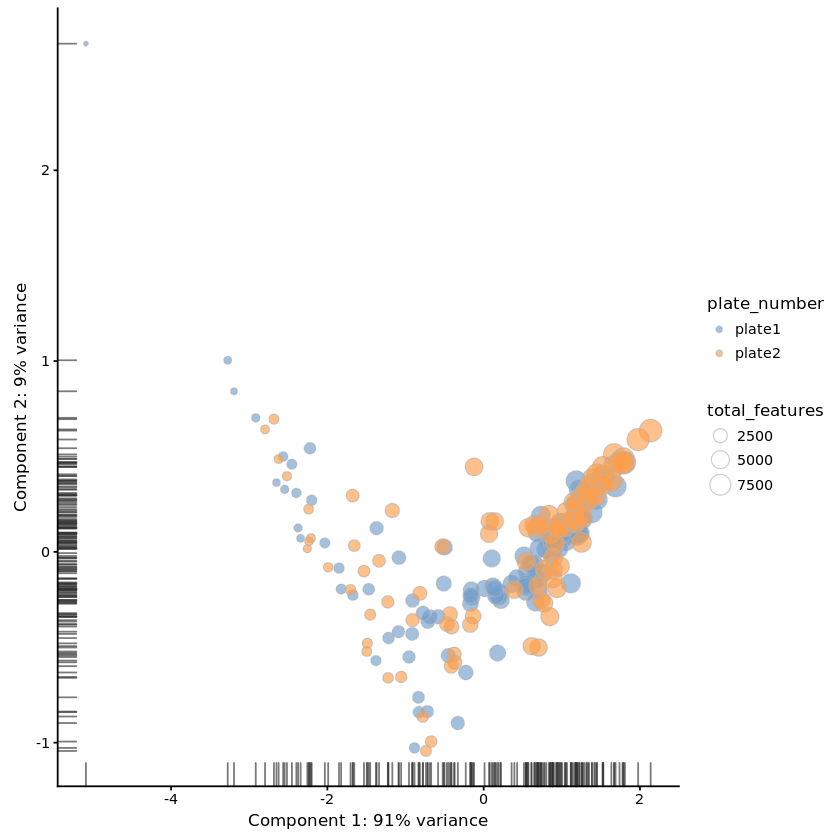

In [92]:
# Automatic filtering params below:
#  -- We shape by filter_lowgenes to see if our manual estimate is good
#     This does not affect the outlier detection
message("Here we confirm that plate number has no effect on the data")
plotPCA(
    sce,
    size_by = "total_features", 
    colour_by = "plate_number",
    pca_data_input = "pdata"
)

Let us now use the plotPCA function to perform outlier detection
The following selected_variables were not found in colData(object): pct_counts_feature_controlsThe following selected_variables were not found in colData(object): total_features_feature_controlsThe following selected_variables were not found in colData(object): log10_total_counts_endogenousThe following selected_variables were not found in colData(object): log10_total_counts_feature_controls
Other variables from colData(object) can be used by specifying a vector of variable names as the selected_variables argument.
PCA is being conducted using the following variables:pct_counts_top_100_featurestotal_features


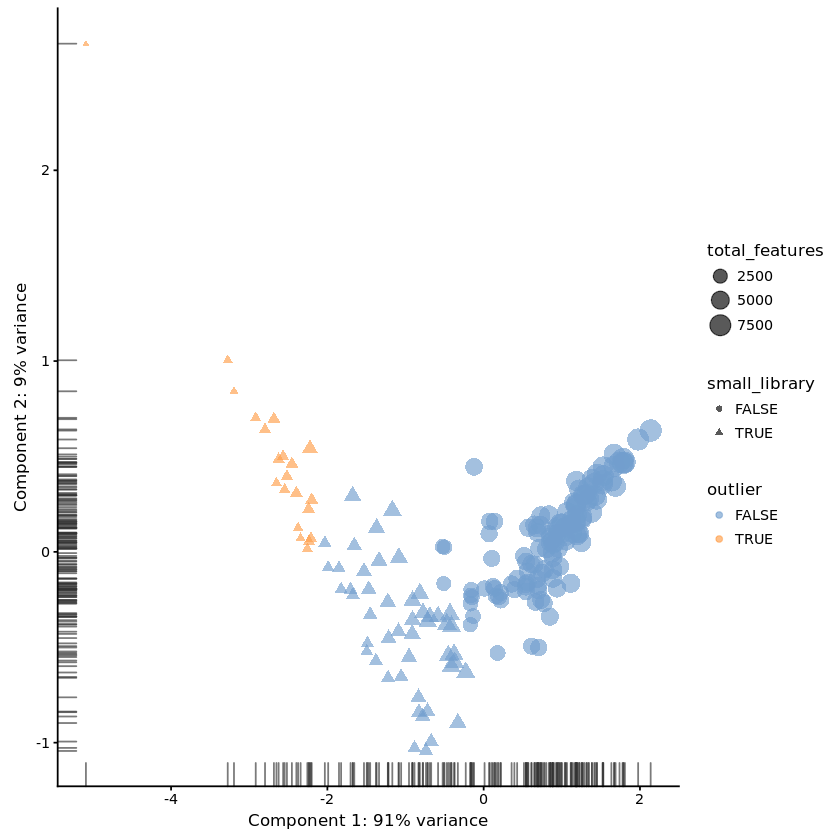

Notice that the automatic outlier detection is in accordance with our assumption that most of
the outlier cells will have a smaller selection of unique genes


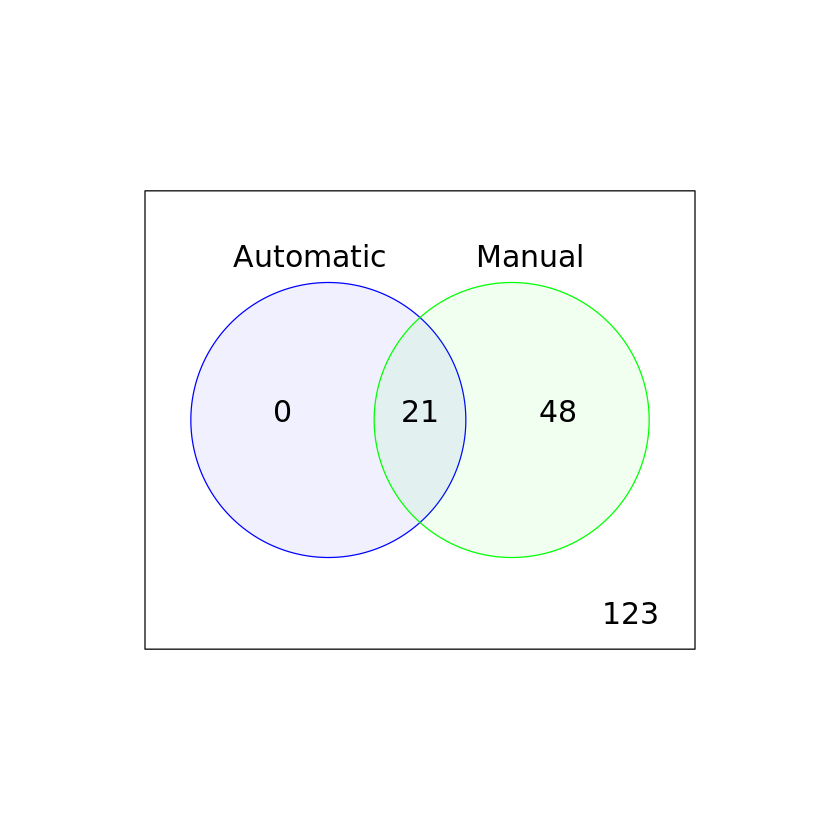

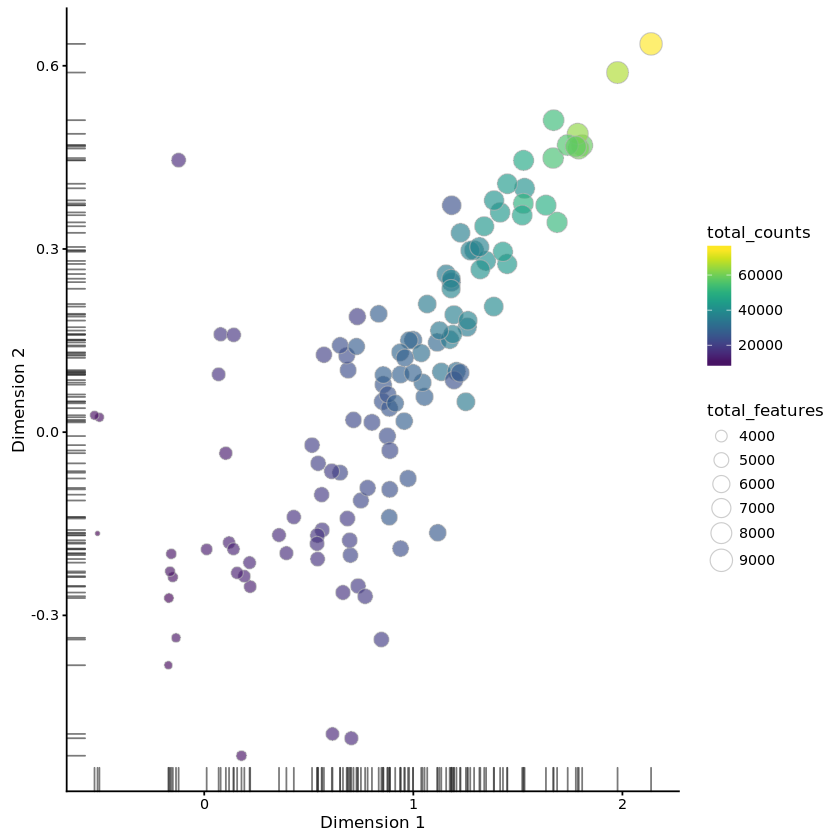

Isolating the two gene library subgroups does not improve the PCA. Outlier detection
does not change based on any of the 4 metrics defined above. We must use a better filtering
scheme.


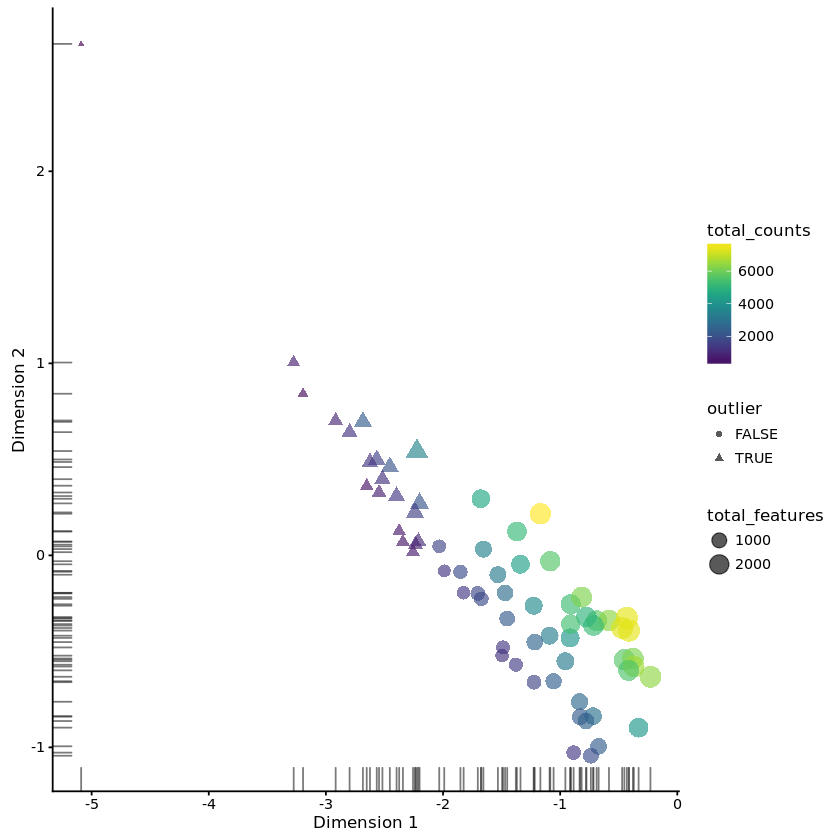

In [93]:
message("Let us now use the plotPCA function to perform outlier detection")

sce <- plotPCA(
    sce,
    size_by = "total_features", 
    shape_by = "small_library",
    pca_data_input = "pdata",
    detect_outliers = TRUE,
    return_SCE = TRUE
)

# Let's see what the overlap is, and how sensitive.
auto <- colnames(sce)[sce$outlier]
man <- colnames(sce)[sce$small_library]

venn.diag <- vennCounts(
    cbind(colnames(sce) %in% auto,
    colnames(sce) %in% man)
)
vennDiagram(
    venn.diag,
    names = c("Automatic", "Manual"),
    circle.col = c("blue", "green")
)

message("Notice that the automatic outlier detection is in accordance with our assumption that most of
the outlier cells will have a smaller selection of unique genes")



plotPCA(
    sce[,sce$large_library],
    size_by = "total_features", 
    shape_by = "outlier",
    pca_data_input = "pdata",
    colour_by = "total_counts"
)

plotPCA(
    sce[,sce$small_library],
    size_by = "total_features", 
    shape_by = "outlier",
    pca_data_input = "pdata",
    colour_by = "total_counts"
)

#
#p2 <- plotPCA(
#    sce,
#    size_by = "total_features", 
#    shape_by = "filter_highgenes",
#    pca_data_input = "pdata",
#    detect_outliers = TRUE,
#    return_SCE = TRUE
#)
#
#p2 <- plotPCA(
#    sce,
#    size_by = "total_features", 
#    shape_by = "filter_lowgenes",
#    pca_data_input = "pdata",
#    detect_outliers = TRUE,
#    return_SCE = TRUE
#)
## Outlier detection is the same for all below, no need to plot all here.
message("Isolating the two gene library subgroups does not improve the PCA. Outlier detection
does not change based on any of the 4 metrics defined above. We must use a better filtering
scheme.")

Now let's examine the gene expression of the top 50 most expressive genes, looking for any technical artefacts and an approximation of the coverage.


Generally flat distributions for all, hinting at good overall coverage


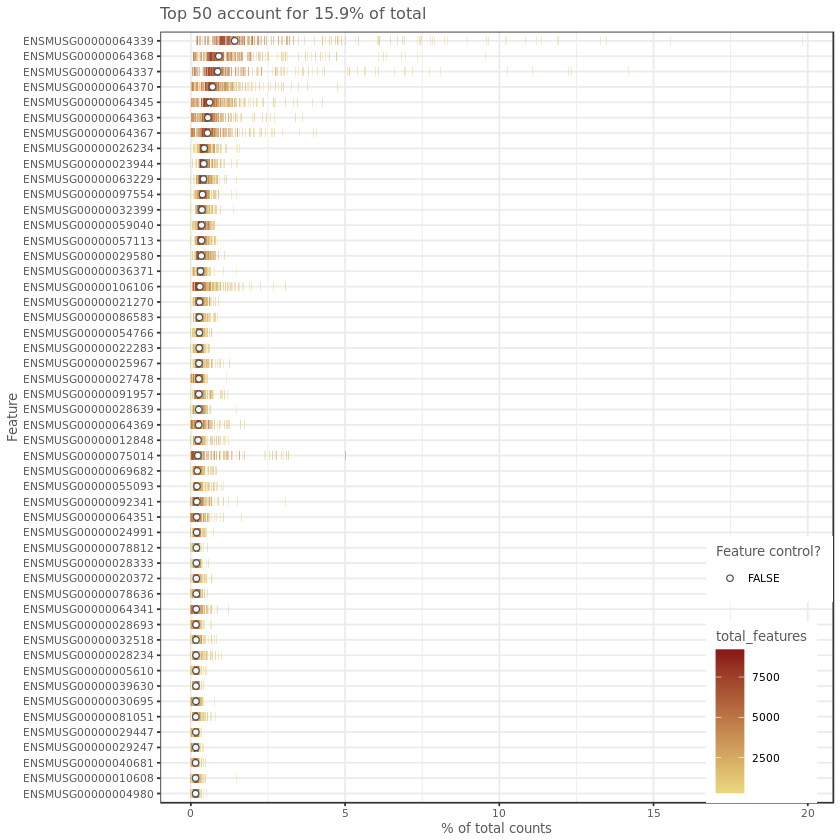

But most genes are lowly expressed (as expected for the platform)


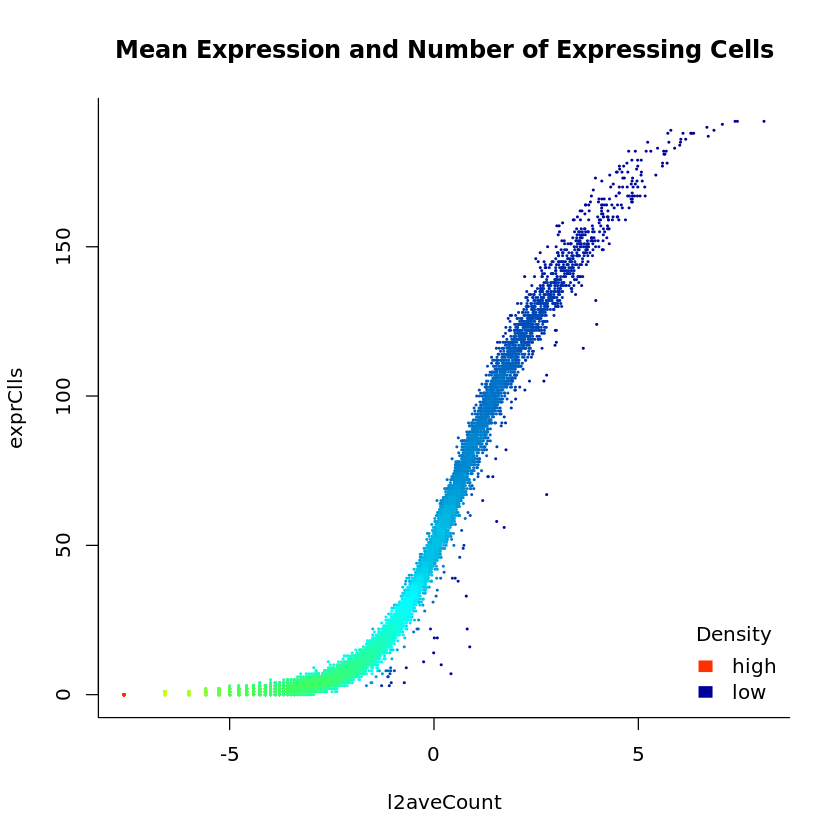

In [99]:
message("Now let's examine the gene expression of the top 50 most expressive genes, looking for any technical artefacts and an approximation of the coverage.")

genes_of_interest <- c(
    "Eomes", "Brachyury", "Mesp1",                # meso
    "Pou5f1", "nanog",                            # pluripotent
    "Sox1", "Sox2", "Pou3f1", "zfp462", "slc7a3") # neuroectoderm

plotQC(sce, type = "highest-expression")

# Could not plot our genes of interest...
#assay(sce, "logcounts_raw") <- log2(counts(sce) + 1)
#plotExpression(sce, genes_of_interest, exprs_values = "logcounts_raw")

message("Generally flat distributions for all, hinting at good overall coverage")


# Let's have a look at the mean expression and the amount of displaying cells

# determine average expression for cells with more than a single transcript
gene_averages = rowMeans(counts(sce))
# gene_medians = rowMedians(counts(sce)),  ## median would not highlight extremities

expr_cells <- apply(counts(sce), 1, function(x) {sum(x > 1)})

df <- data.frame(
  l2aveCount = log2(gene_averages), 
  exprClls = expr_cells
)
arr <- densCols(df$exprClls, df$l2aveCount, 
                colramp = colorRampPalette(c("black", "white")))
df$dens <- col2rgb(arr)[1, ] + 1L
cols <-  colorRampPalette(c("#000099", "#00FEFF", "#45FE4F", "#FCFF00", 
                            "#FF9400", "#FF3100"))(256)
df$col <- cols[df$dens]
plot(
    exprClls ~ l2aveCount, data = df[order(df$dens), ],
    pch = 20, col = col,
    cex = 0.3, bty = "l",
    main = "Mean Expression and Number of Expressing Cells"
    #xlim = c(-8,2), ylim = c(0,100)
)
legend("bottomright", c("high", "low"), fill = c("#FF3100", "#000099"), 
       border = "white", bty = "n", title = "Density")
    
message("But most genes are lowly expressed (as expected for the platform)")


In [103]:
## Mild gene filtering for "detectable" genes. 
## - This should still keep in most rare cell types, as we are only confirming that a single
##   transcript is confirmed by at least one other cell.
## - Only complete (and unverifiable) singleton cells will be removed.


message("Let's filter for 'detectable' genes: i.e. genes that have at least 1 or 2 transcripts in at least two cells")

detectable_genes_thresh1 <- apply(
    counts(sce),
    1,
    function(x){length(x[x >= 1]) >= 2 }
)

detectable_genes_thresh2 <- apply(
    counts(sce),
    1,
    function(x){length(x[x >= 2]) >= 2 }
)


message(sprintf("Threshold1: %.0f of the %.0f genes (%.0f%%) are detectable by at least 1 transcript  in at least 2 cells",
                sum(detectable_genes_thresh1),
                length(detectable_genes_thresh1),
                100 * sum(detectable_genes_thresh1) / length(detectable_genes_thresh1)
        )
)

message(sprintf("Threshold2: %.0f of the %.0f genes (%.0f%%) are detectable by at least 2 transcripts in at least 2 cells",
                sum(detectable_genes_thresh2),
                length(detectable_genes_thresh2),
                100 * sum(detectable_genes_thresh2) / length(detectable_genes_thresh2)
        )
)

rowData(sce)$dgt_1 <- detectable_genes_thresh1
rowData(sce)$dgt_2 <- detectable_genes_thresh2

Let's filter for 'detectable' genes: i.e. genes that have at least 1 or 2 transcripts in at least two cells
Threshold1: 16658 of the 20662 genes (81%) are detectable by at least 1 transcript  in at least 2 cells
Threshold2: 10753 of the 20662 genes (52%) are detectable by at least 2 transcripts in at least 2 cells


Applying Threshold1
Applying Threshold2


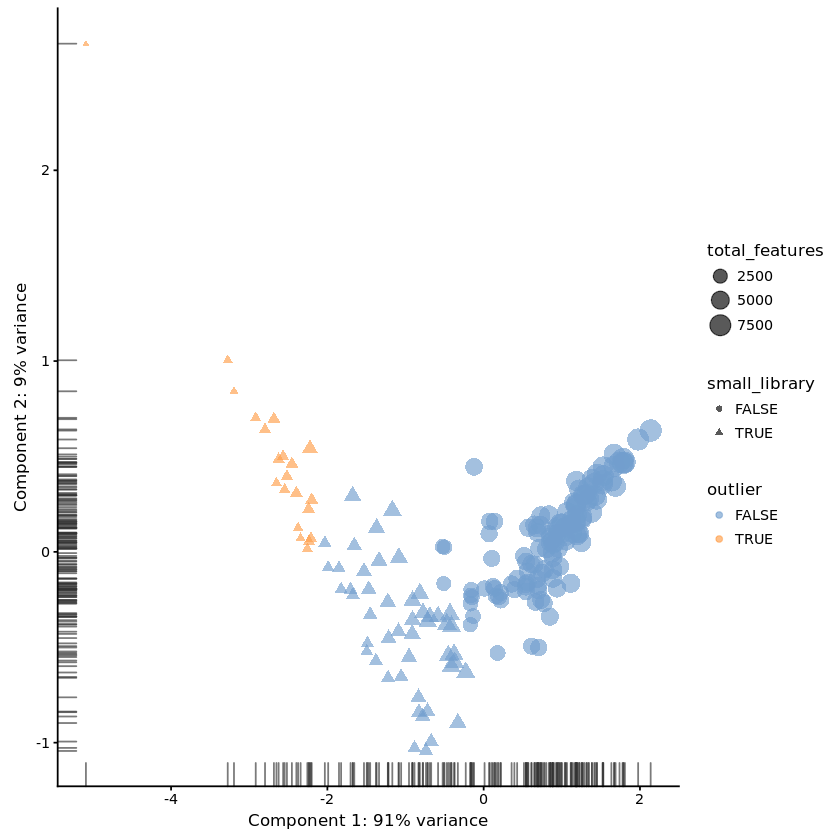

Filtering still does not seem to affect the PCA.


,Genes,Cells
Raw,20662,192
Thresh1,16658,192
Thresh2,10753,192


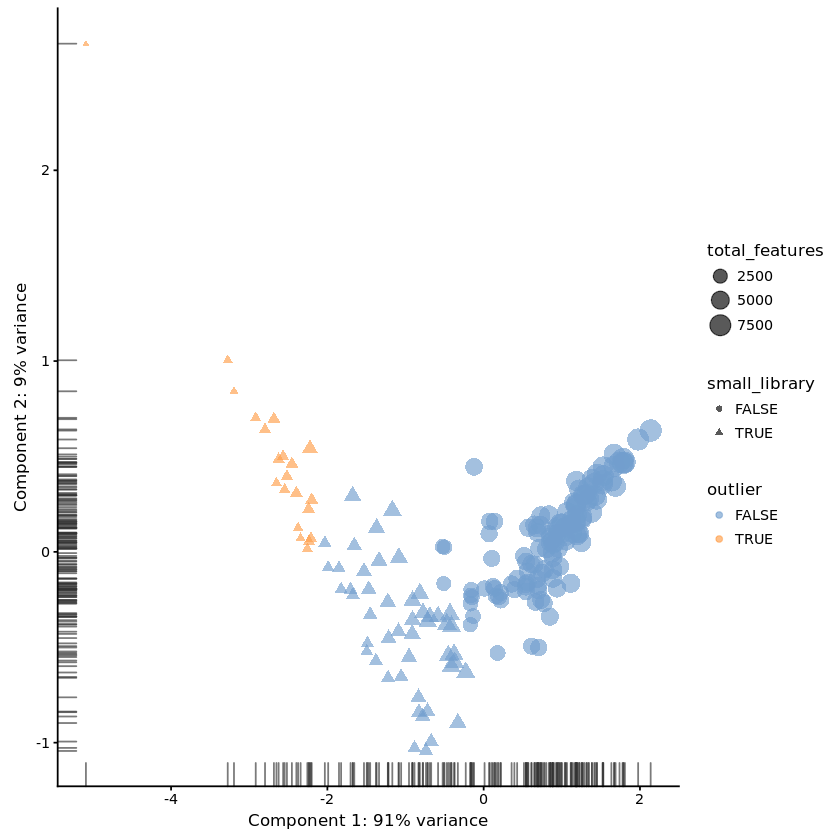

In [122]:
message("Applying Threshold1")

sce.thresh1 <- plotPCA(
    sce[rowData(sce)$dgt_1,],
    size_by = "total_features", 
    shape_by = "small_library",
    colour_by = "outlier",
    pca_data_input = "pdata",
    return_SCE = TRUE
)


message("Applying Threshold2")

sce.thresh2 <- plotPCA(
    sce[rowData(sce)$dgt_2,],
    size_by = "total_features", 
    shape_by = "small_library",
    colour_by = "outlier",
    pca_data_input = "pdata",
    return_SCE = TRUE
)

message("Filtering still does not seem to affect the PCA.")
rbind( c(" ","Genes","Cells"),
     cbind(c("Raw", "Thresh1", "Thresh2"), rbind(
        dim(sce),
        dim(sce.thresh1),
        dim(sce.thresh2)
    ))
)

Let us see if TSNE plots cluster better.
Note that TSNE clustering is also not affected by the filtering for any thresholds


Perplexity =  1  , Seed =  1 
Perplexity =  1  , Seed =  12 


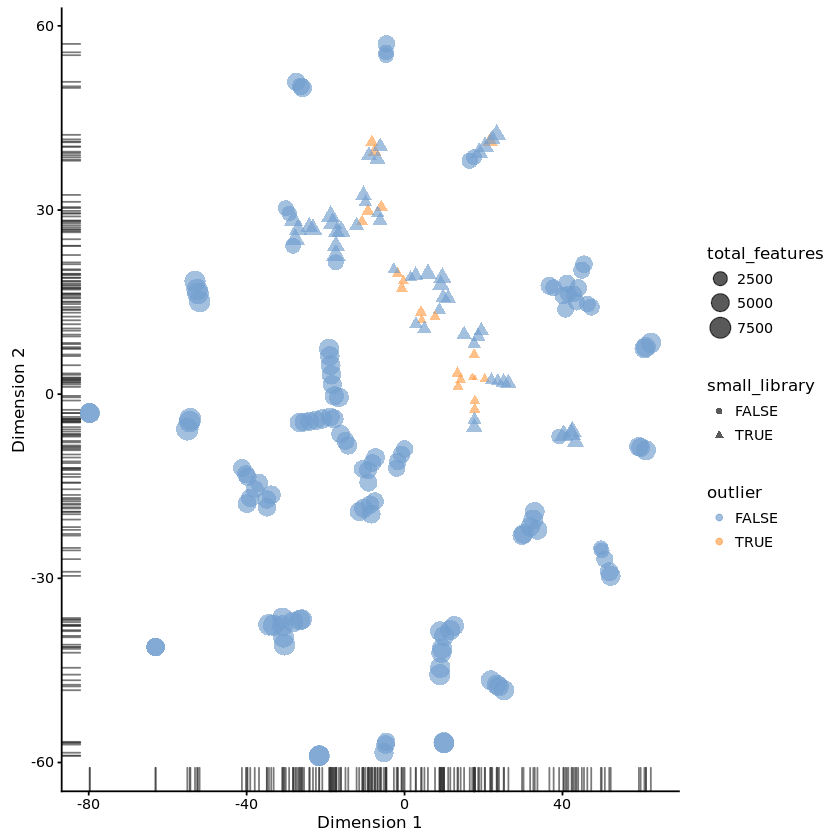

Perplexity =  1  , Seed =  501 


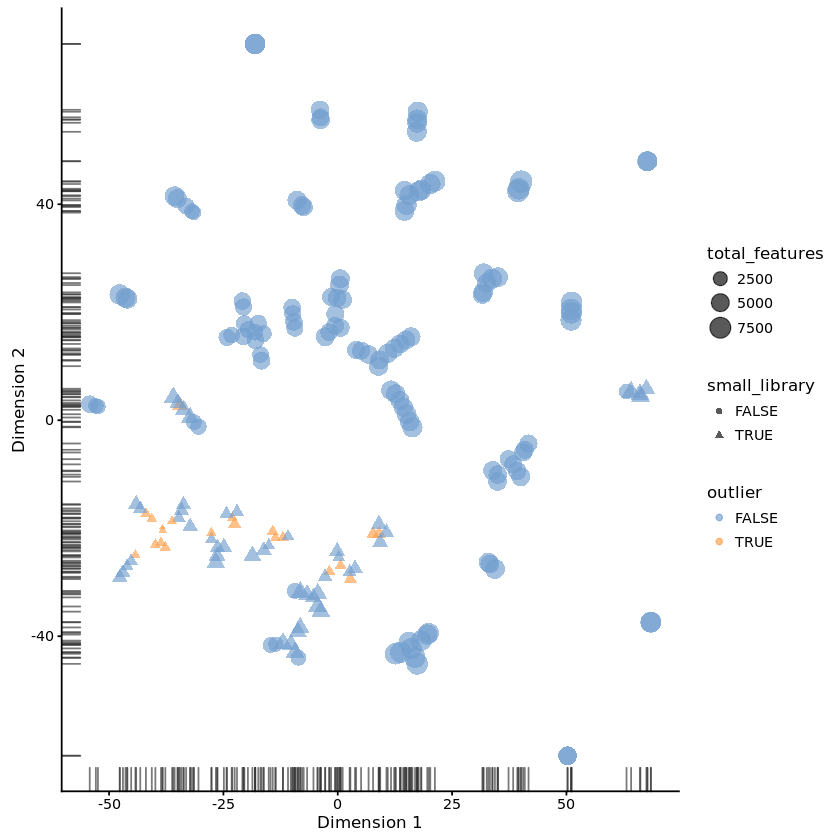

Perplexity =  1  , Seed =  222130 


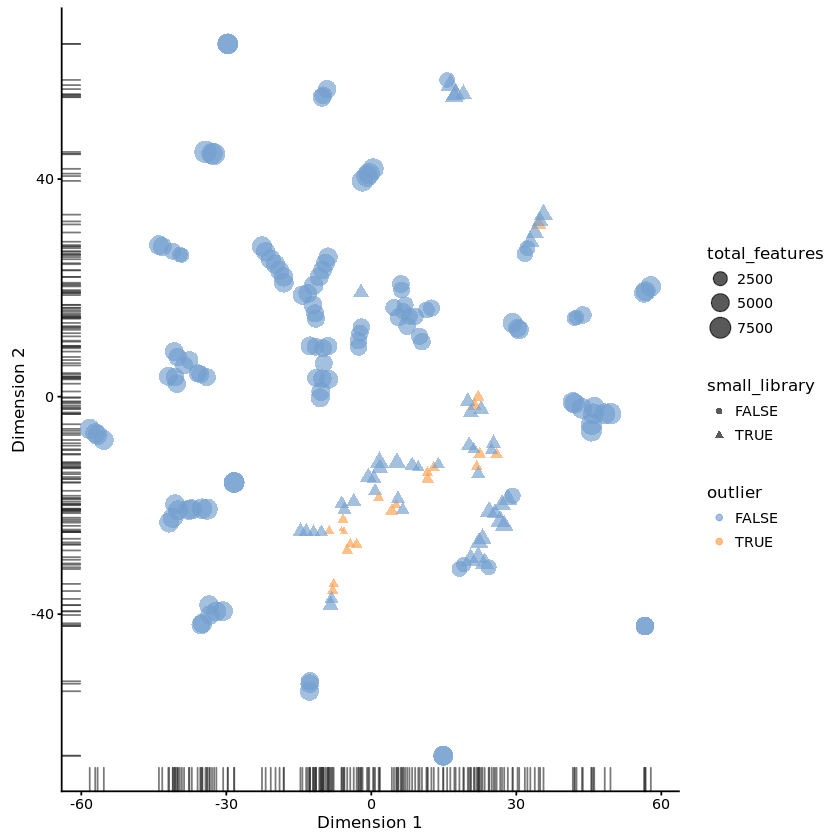

Perplexity =  2  , Seed =  1 


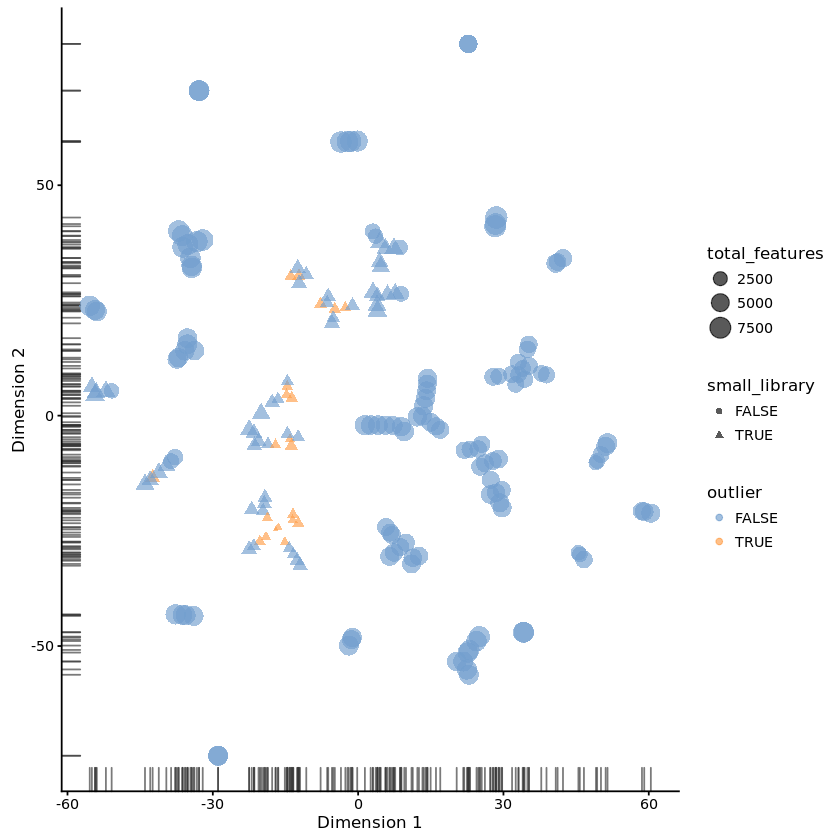

Perplexity =  2  , Seed =  12 


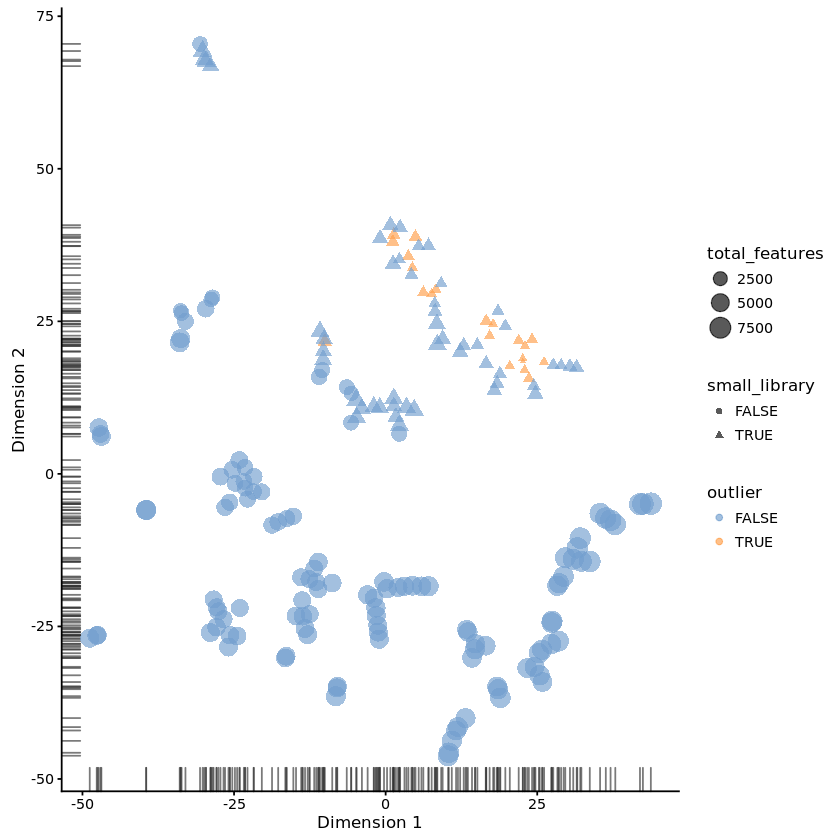

Perplexity =  2  , Seed =  501 


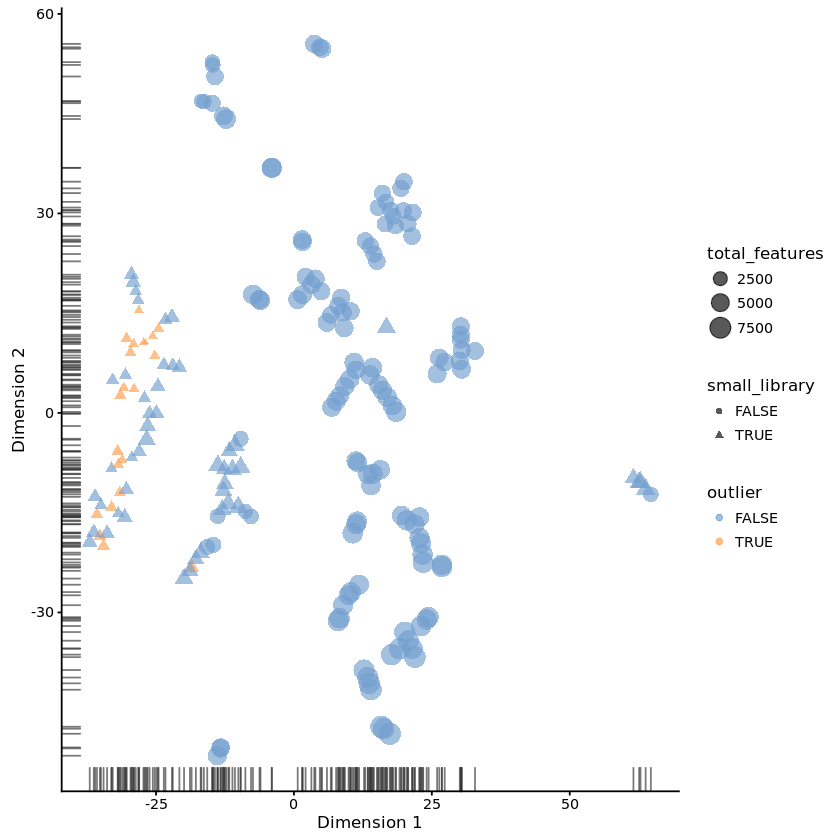

Perplexity =  2  , Seed =  222130 


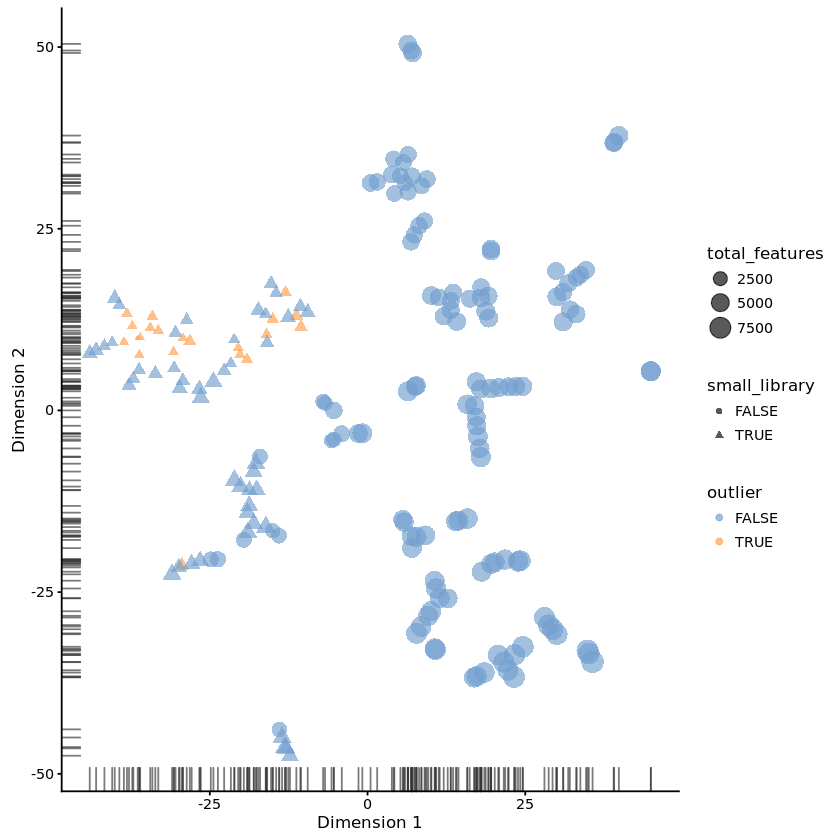

Perplexity =  3  , Seed =  1 


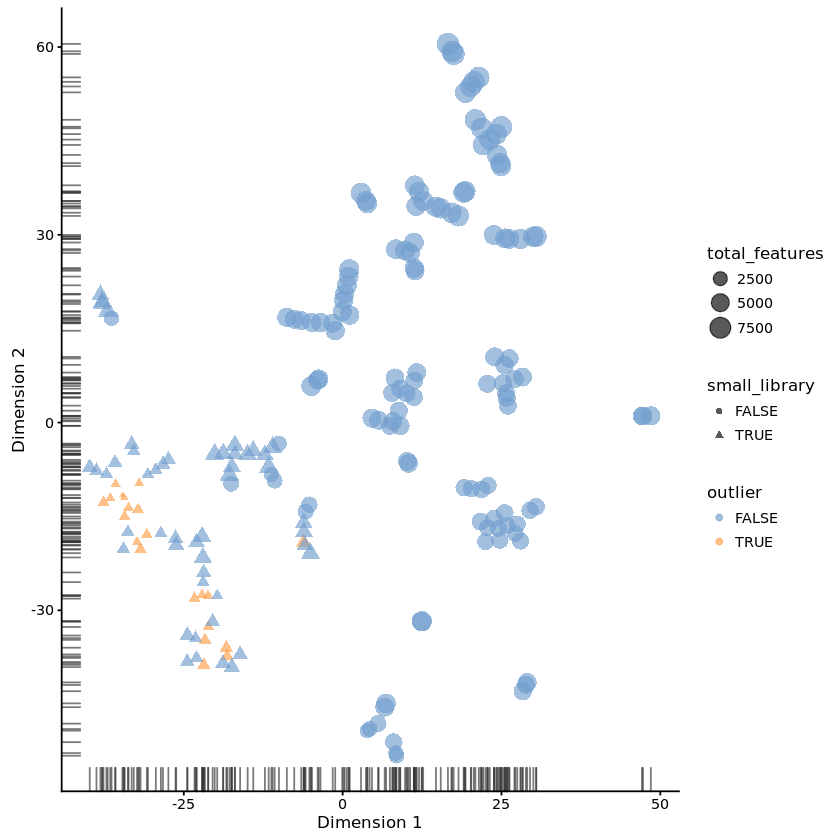

Perplexity =  3  , Seed =  12 


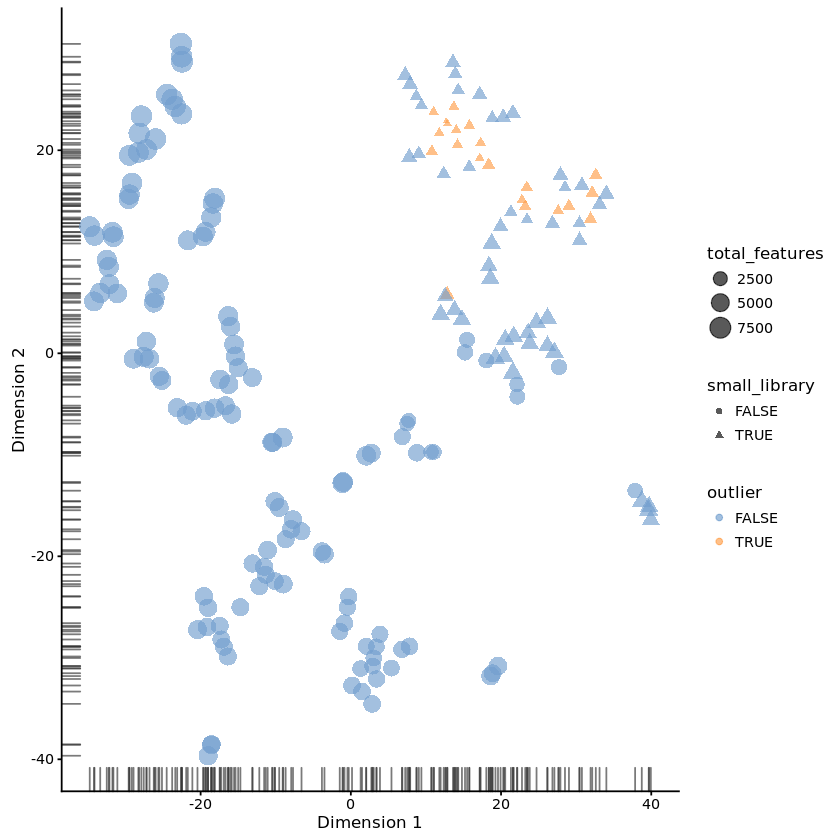

Perplexity =  3  , Seed =  501 


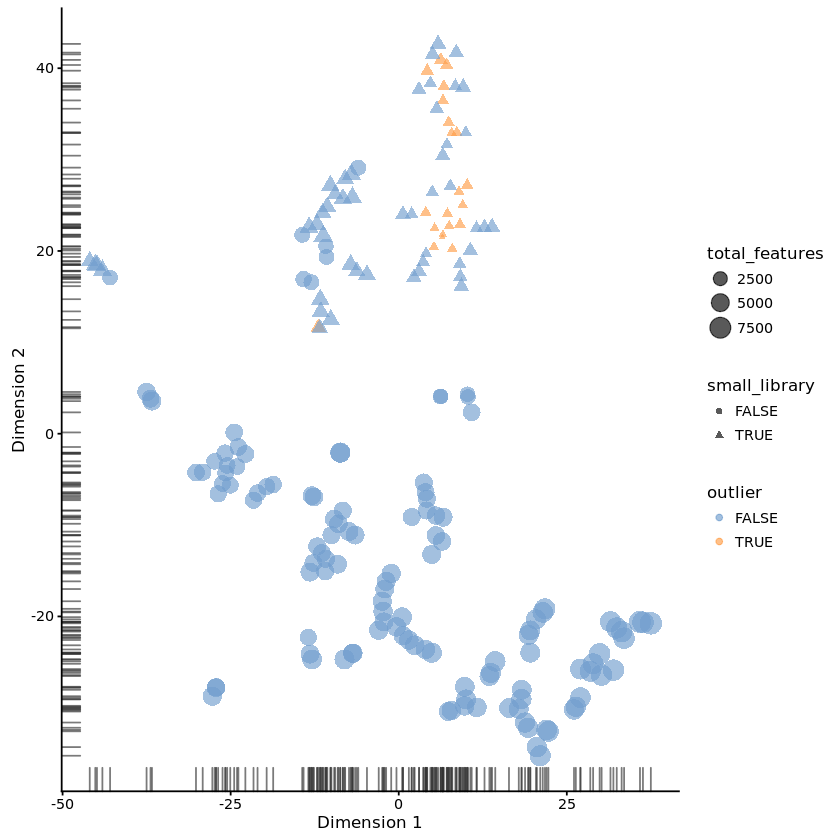

Perplexity =  3  , Seed =  222130 


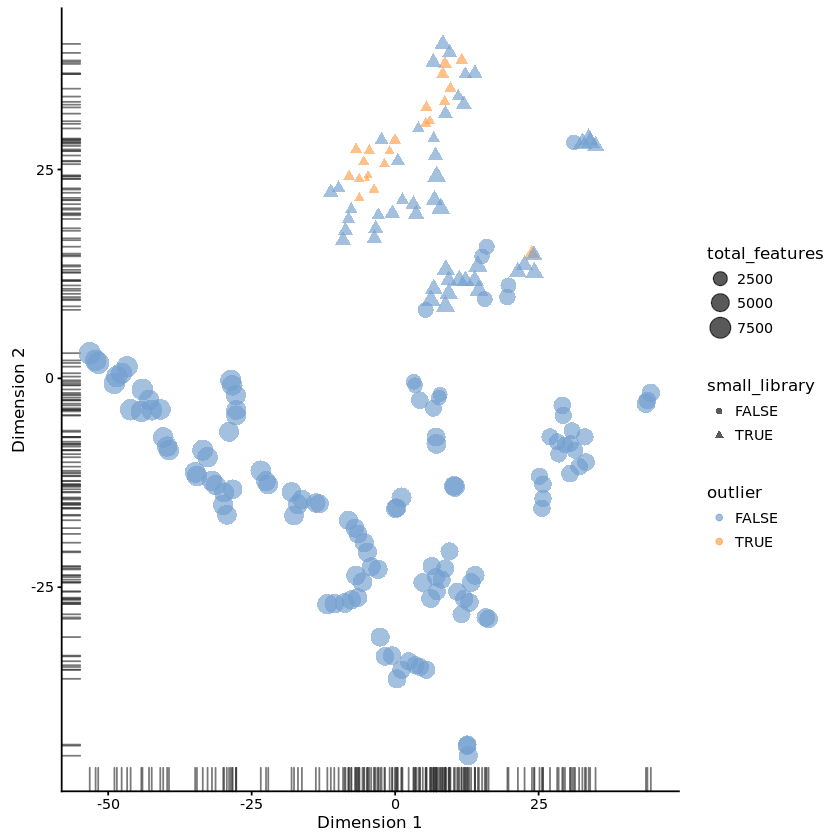

Perplexity =  4  , Seed =  1 


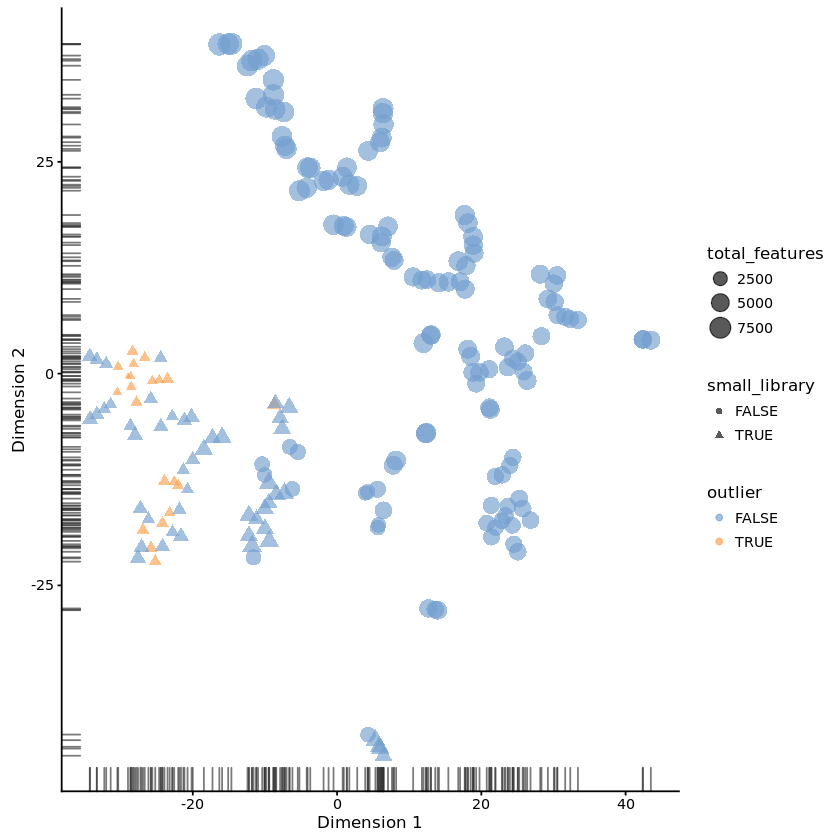

Perplexity =  4  , Seed =  12 


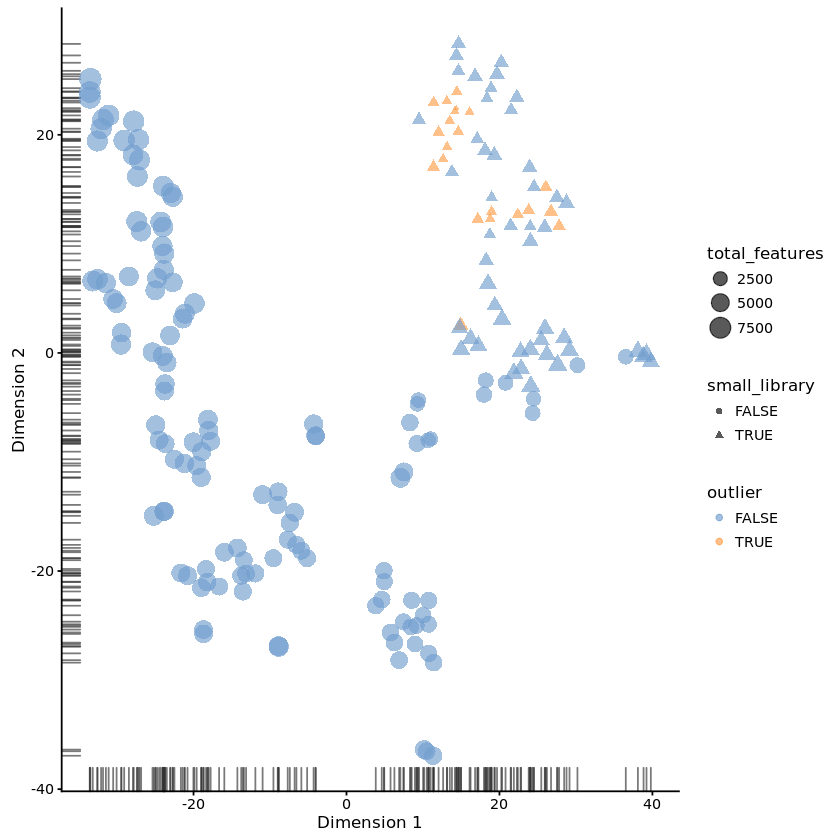

Perplexity =  4  , Seed =  501 


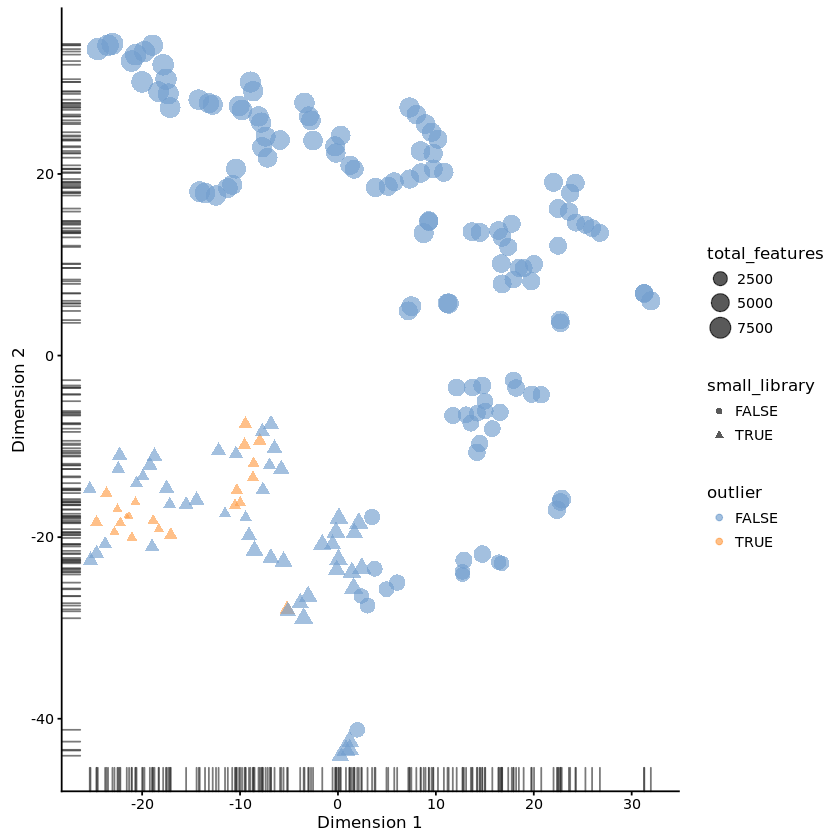

Perplexity =  4  , Seed =  222130 


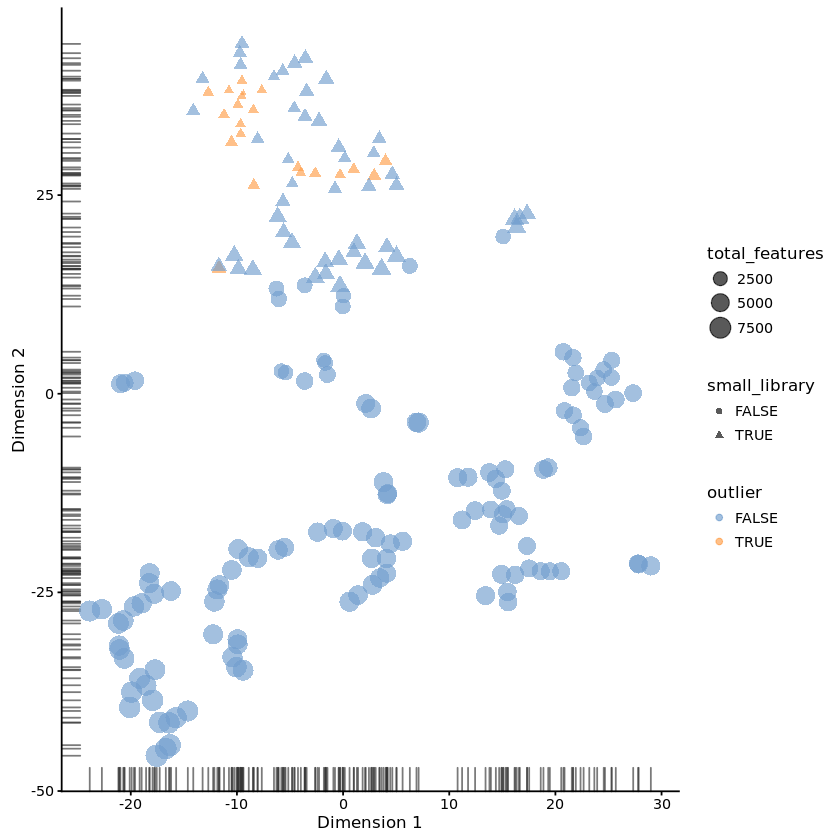

Perplexity =  5  , Seed =  1 


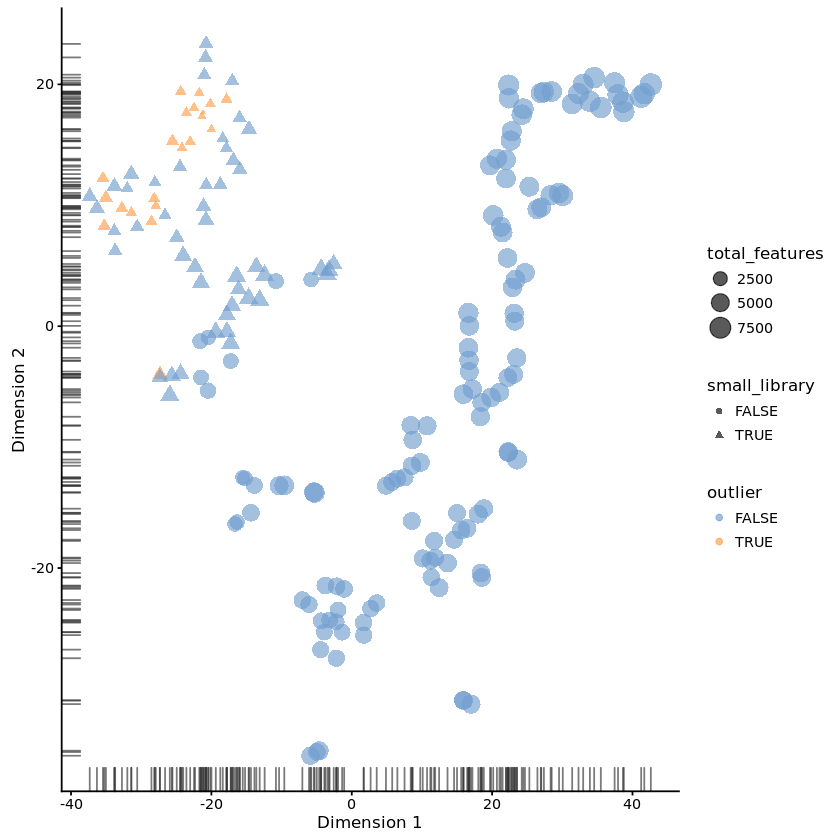

Perplexity =  5  , Seed =  12 


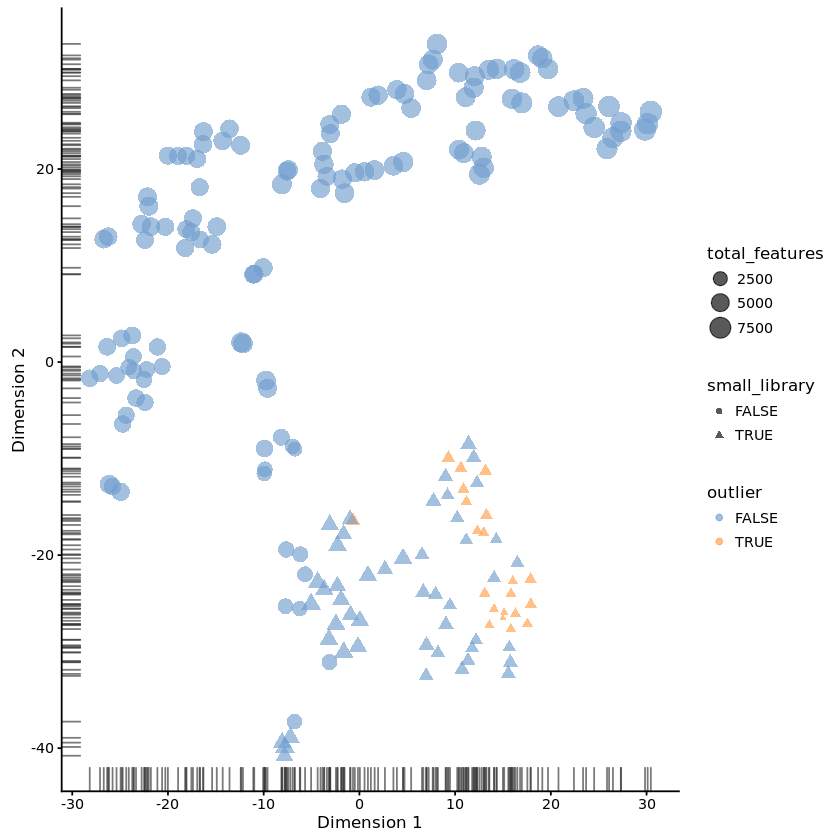

Perplexity =  5  , Seed =  501 


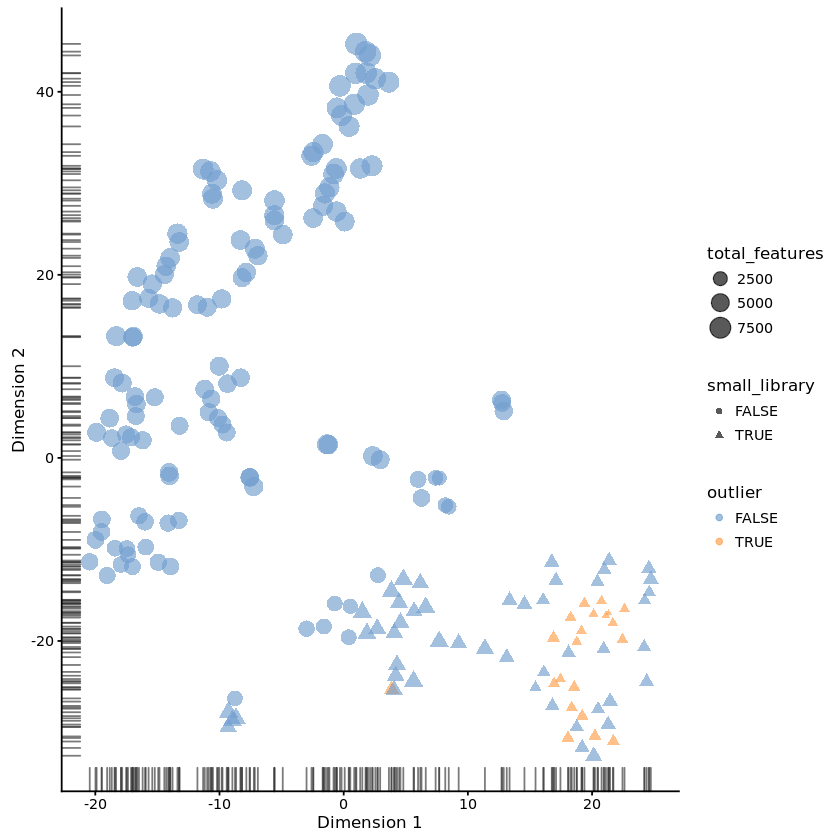

Perplexity =  5  , Seed =  222130 


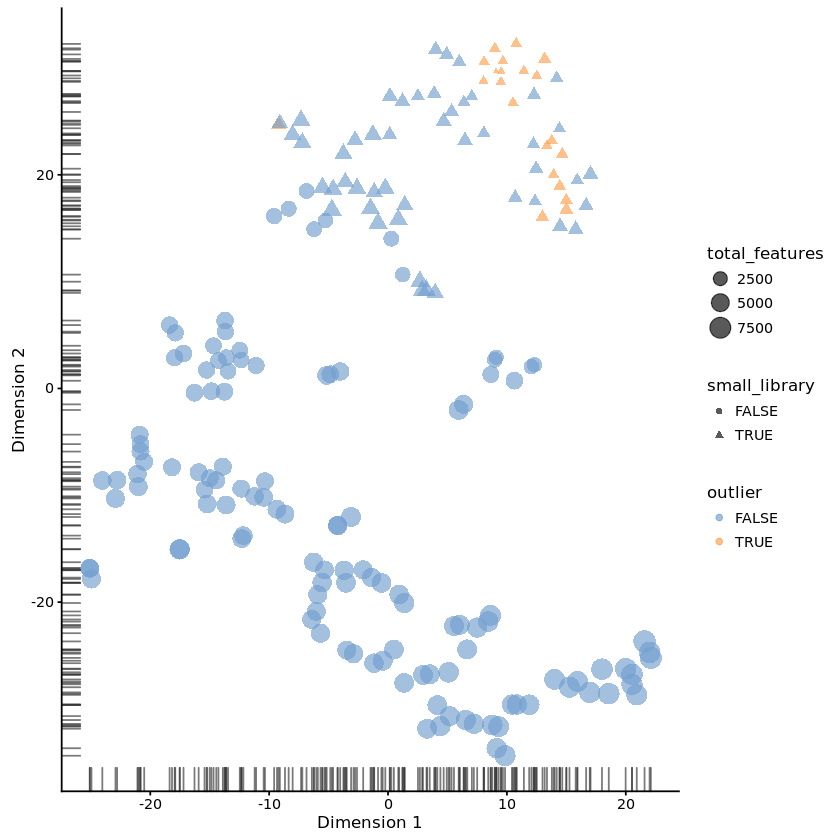

Perplexity =  10  , Seed =  1 


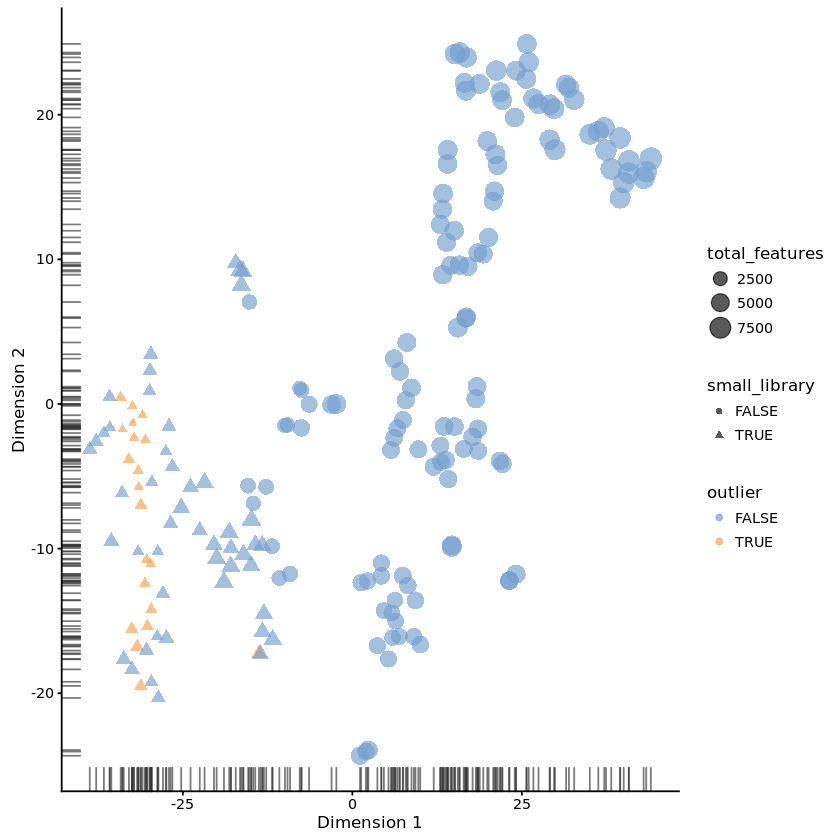

Perplexity =  10  , Seed =  12 


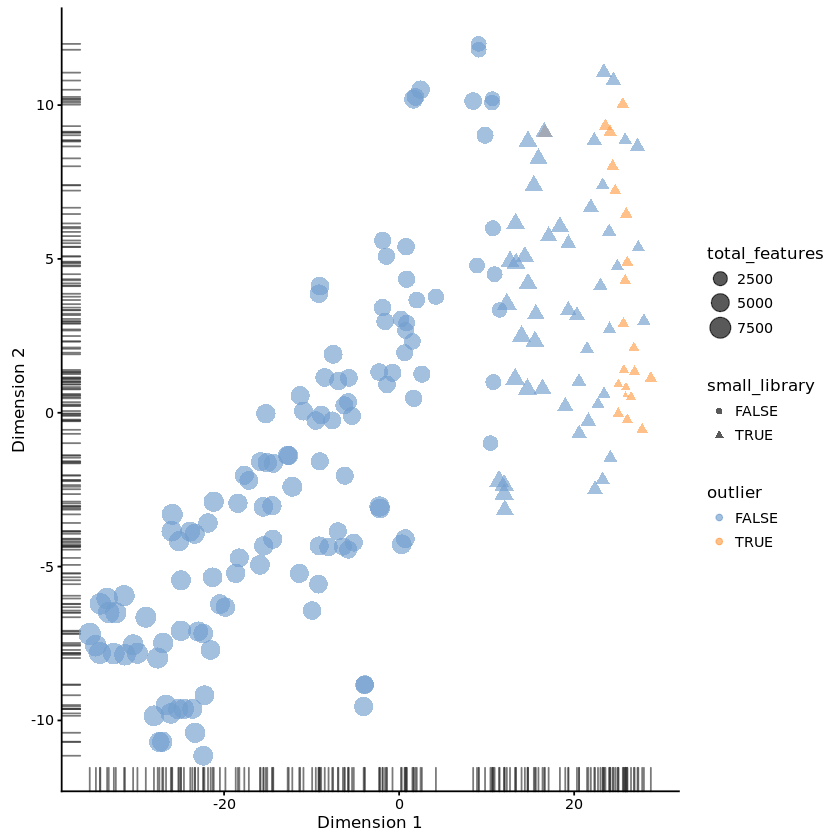

Perplexity =  10  , Seed =  501 


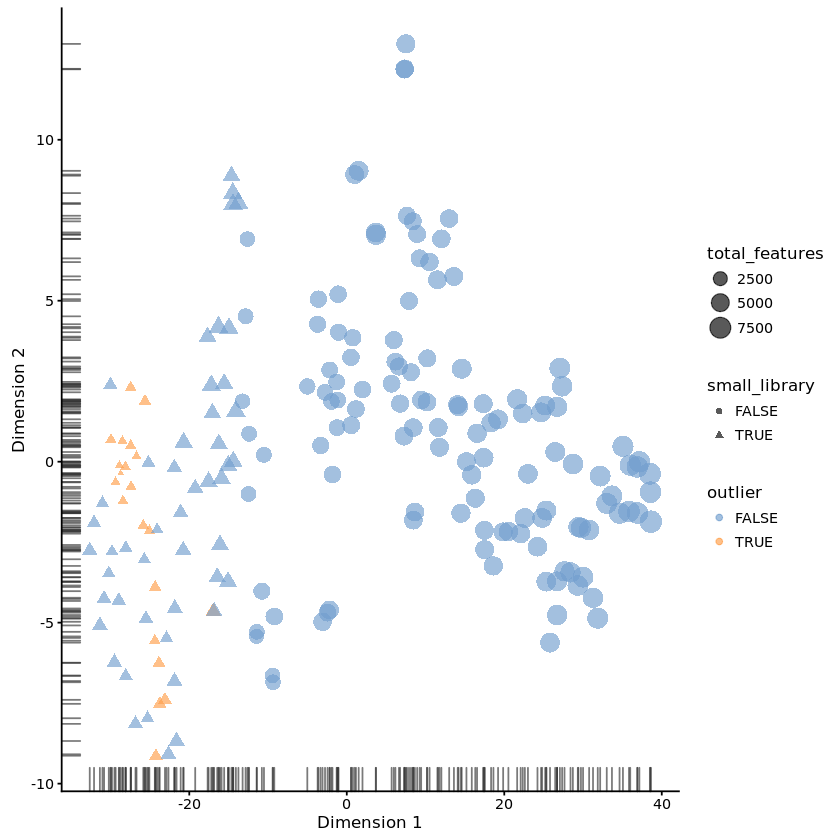

Perplexity =  10  , Seed =  222130 


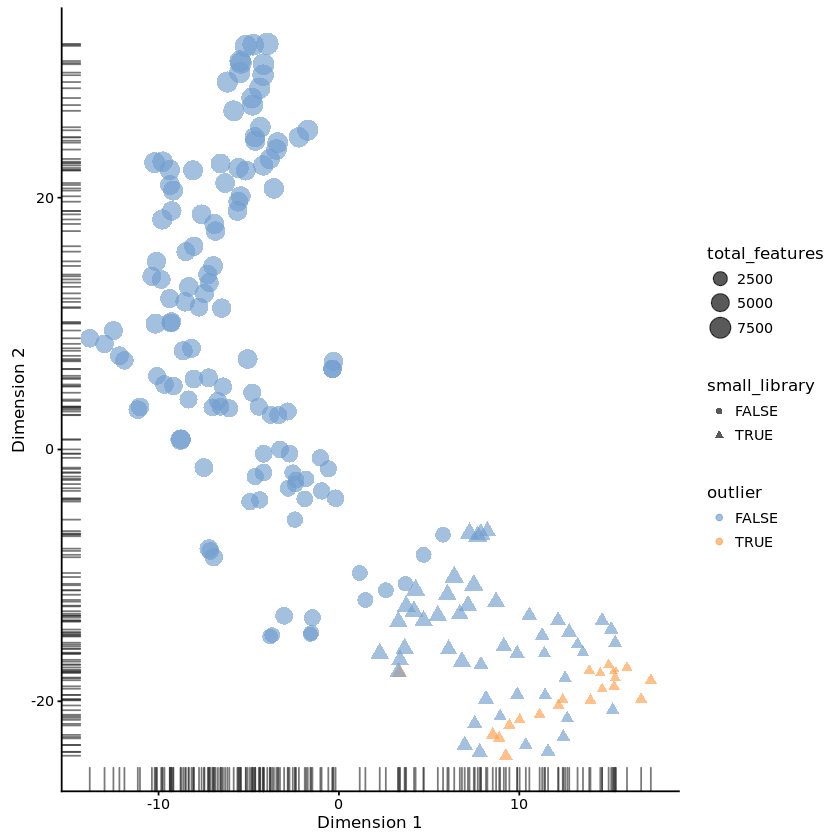

Perplexity =  20  , Seed =  1 


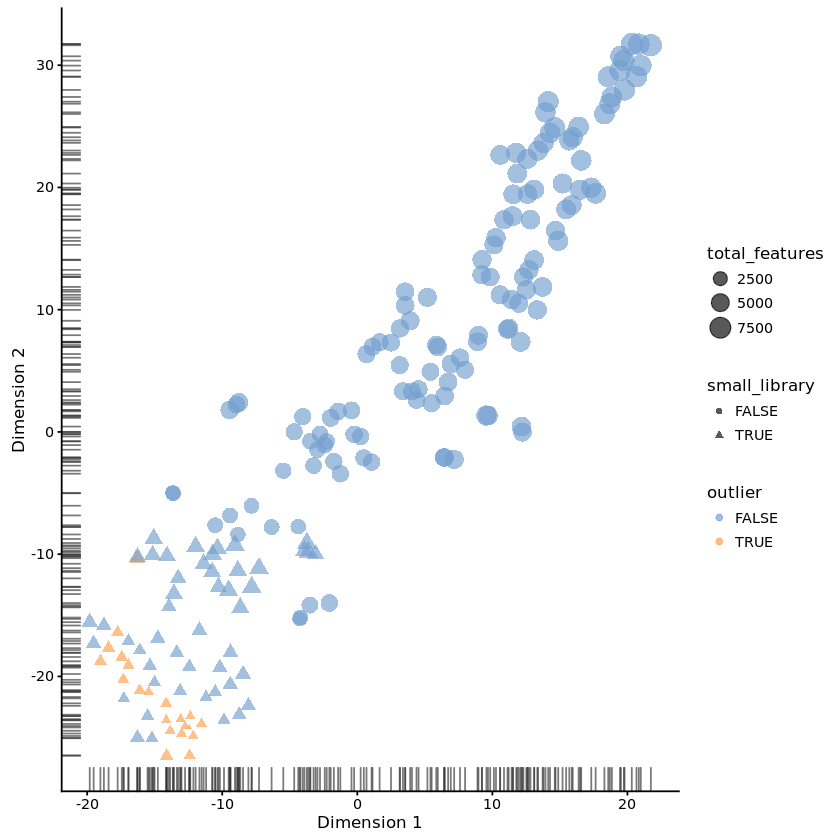

Perplexity =  20  , Seed =  12 


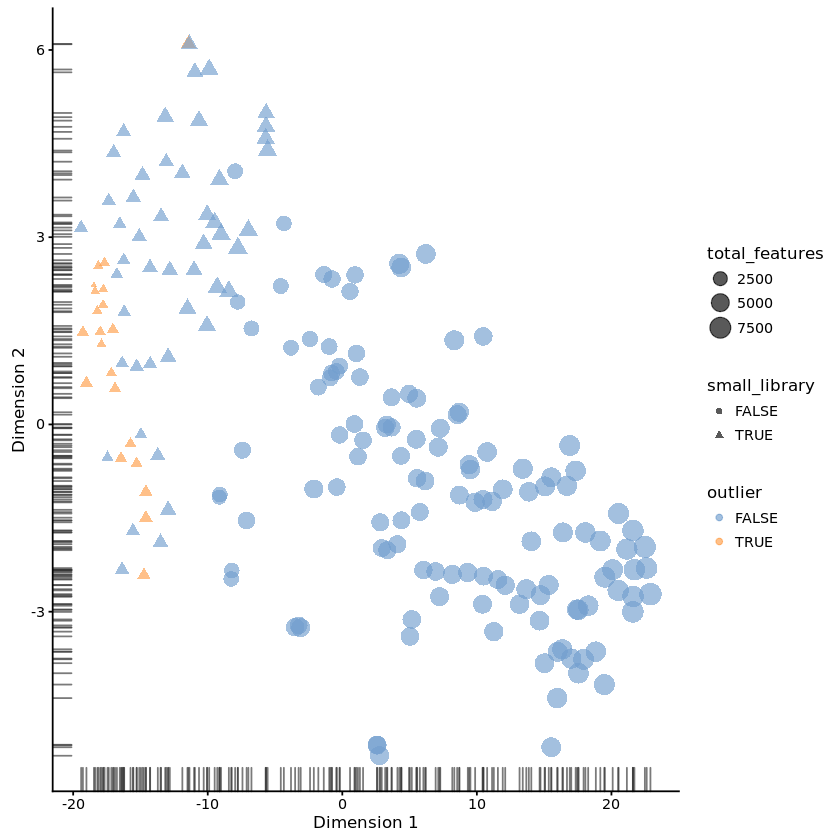

Perplexity =  20  , Seed =  501 


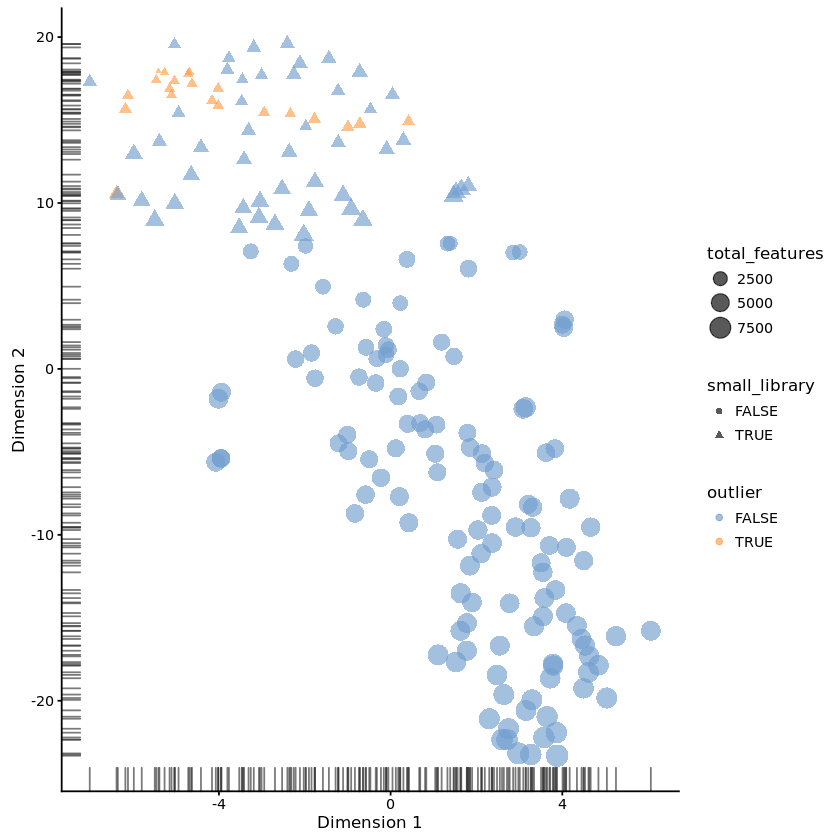

Perplexity =  20  , Seed =  222130 


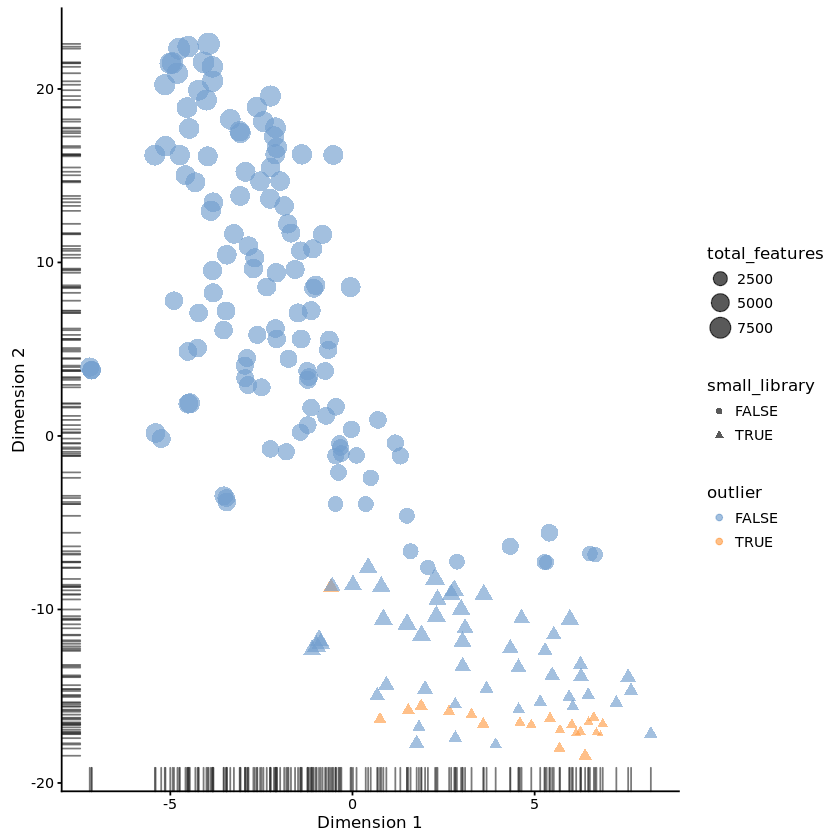

Perplexity =  30  , Seed =  1 


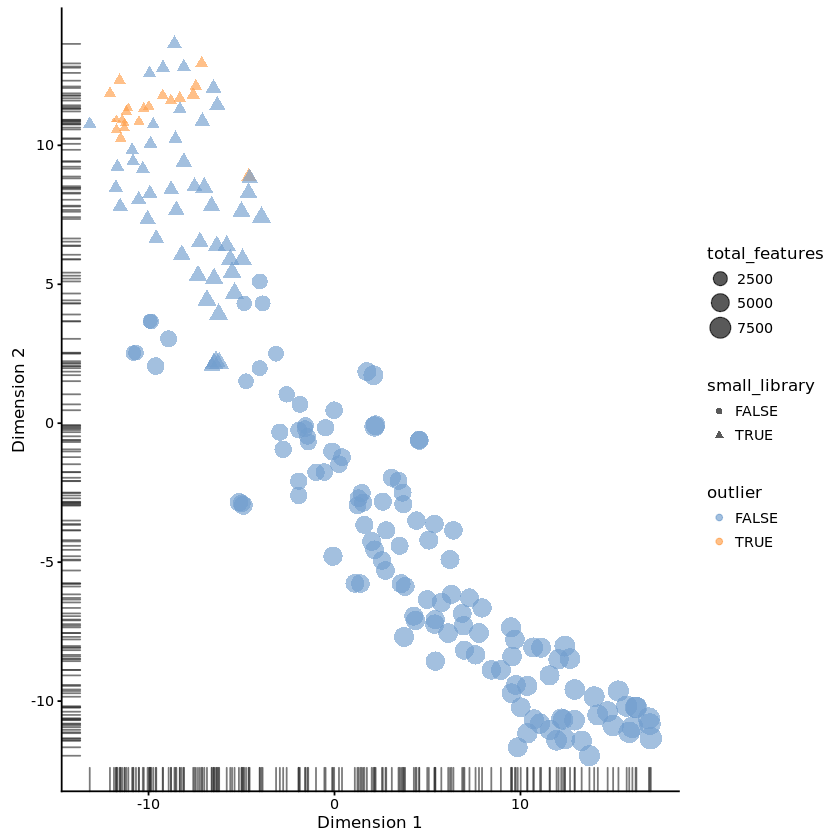

Perplexity =  30  , Seed =  12 


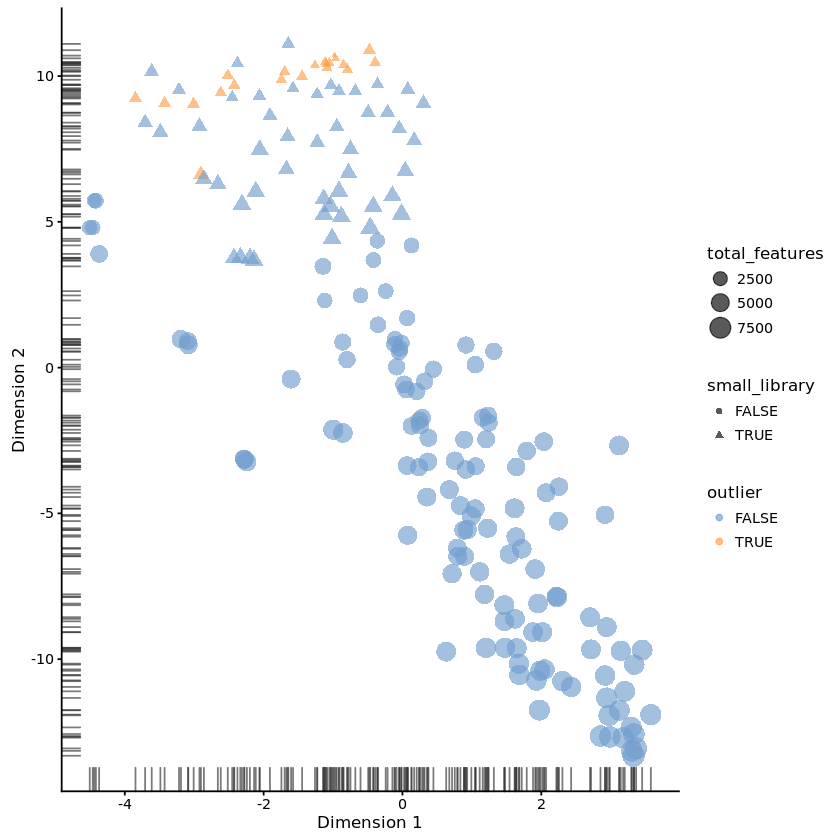

Perplexity =  30  , Seed =  501 


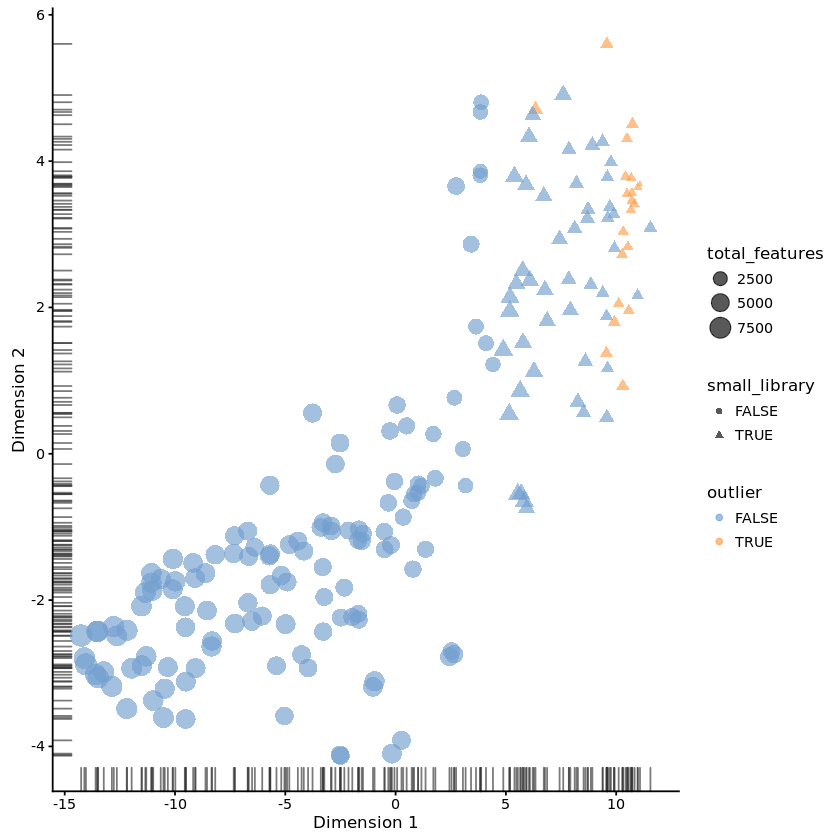

Perplexity =  30  , Seed =  222130 


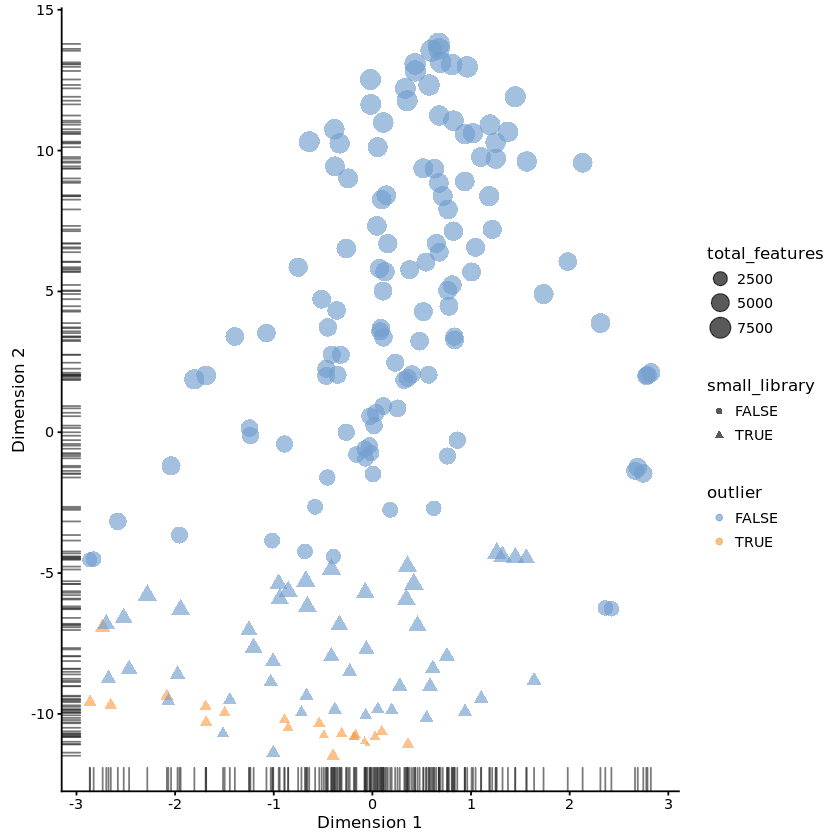

Perplexity =  40  , Seed =  1 


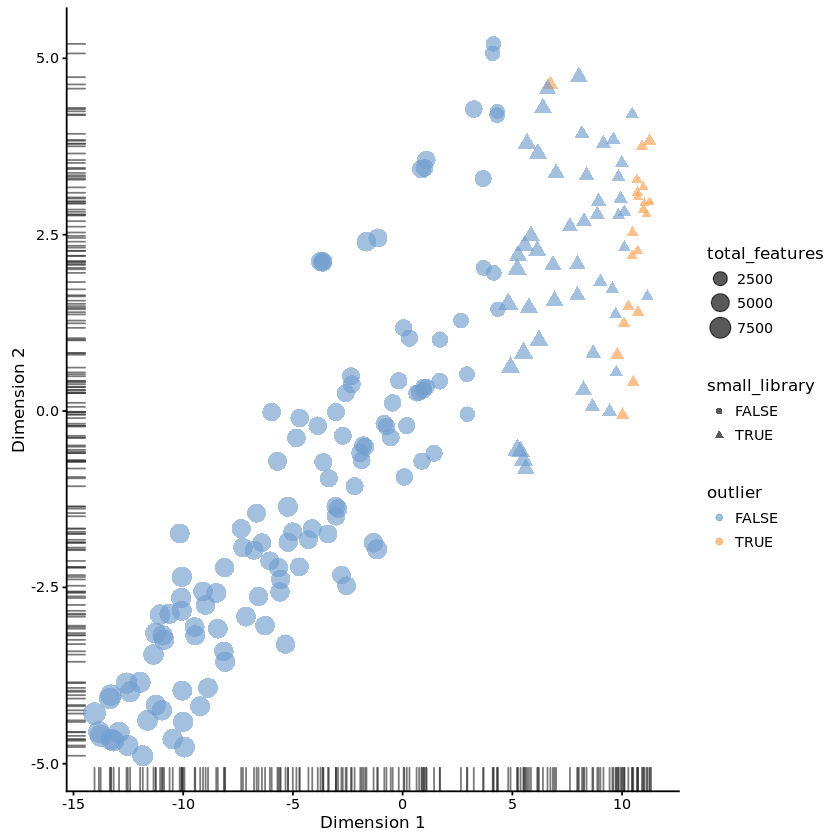

Perplexity =  40  , Seed =  12 


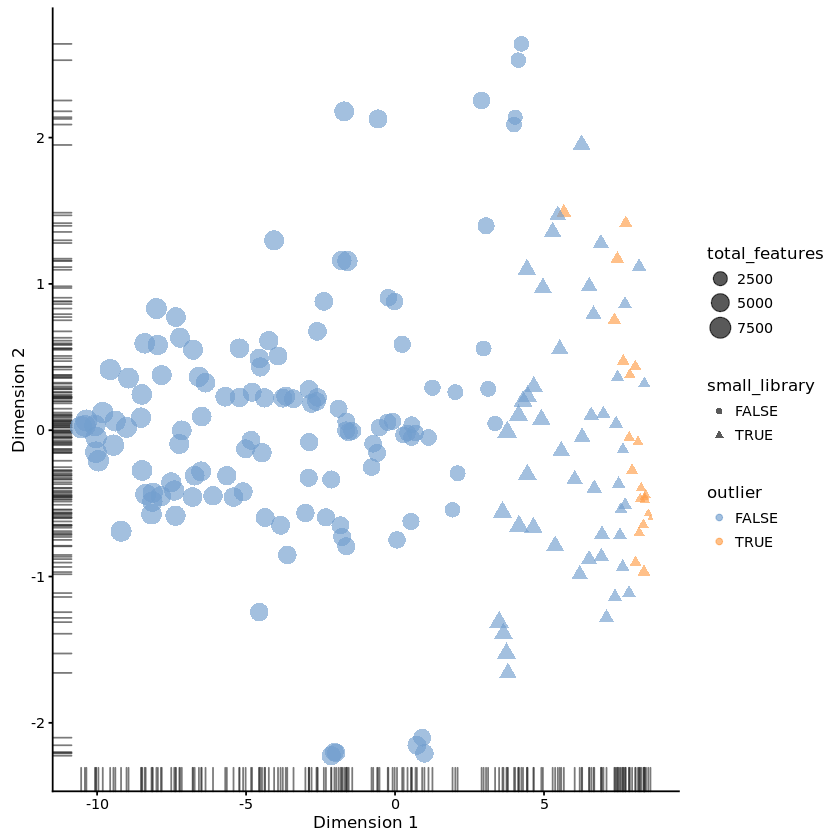

Perplexity =  40  , Seed =  501 


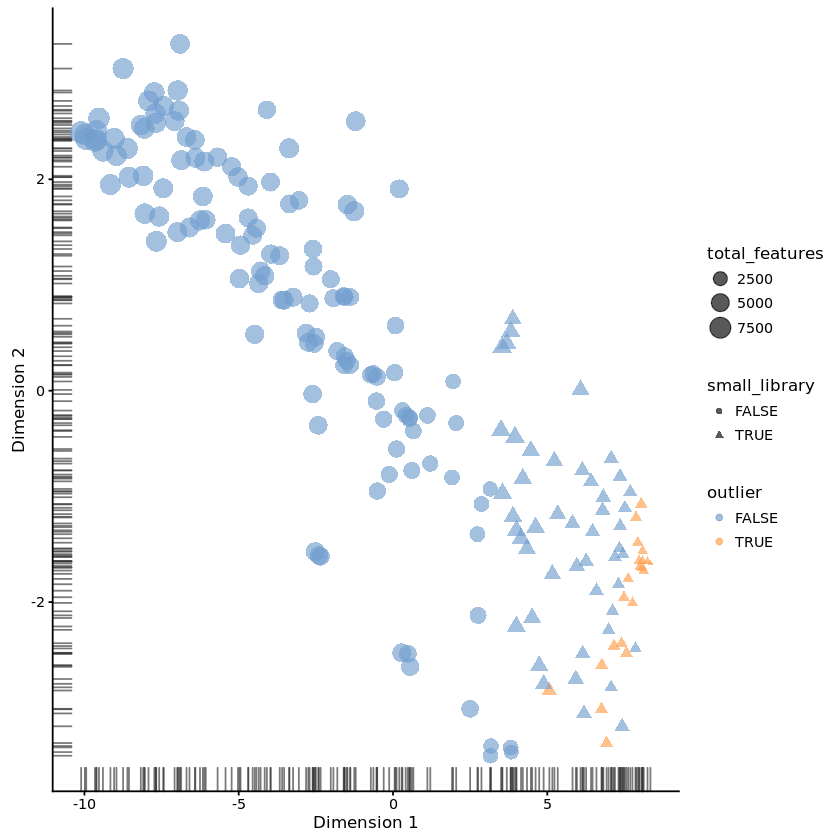

Perplexity =  40  , Seed =  222130 


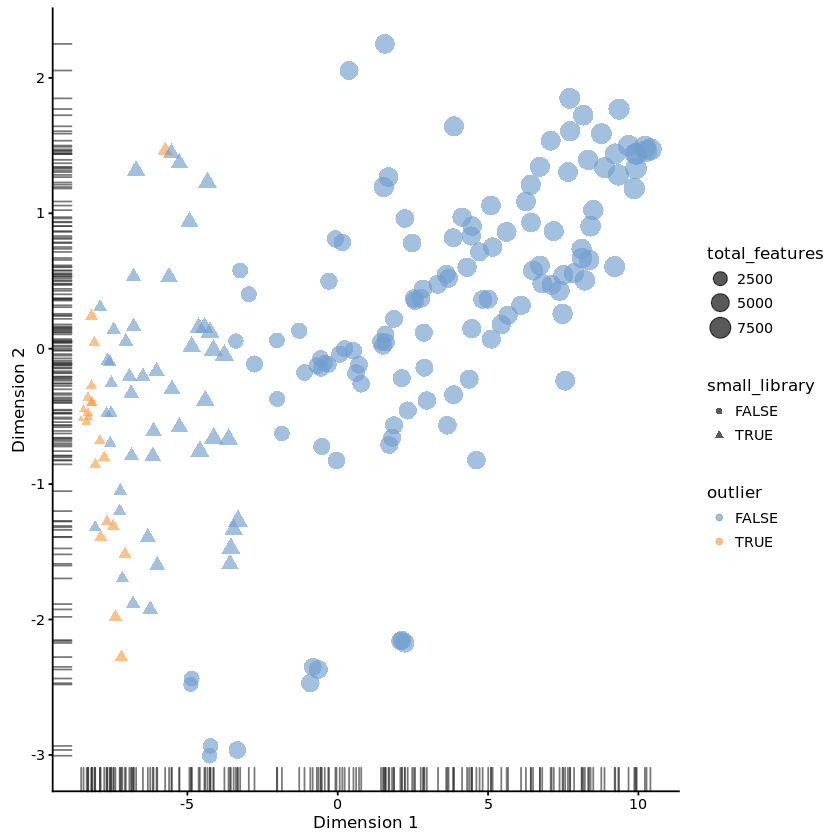

Perplexity =  50  , Seed =  1 


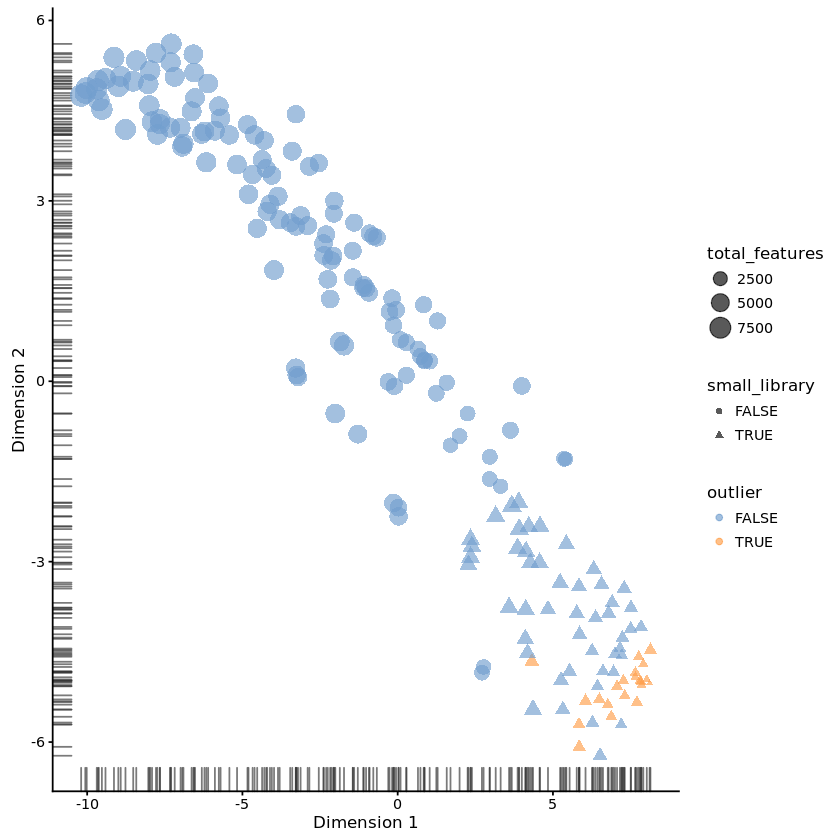

Perplexity =  50  , Seed =  12 


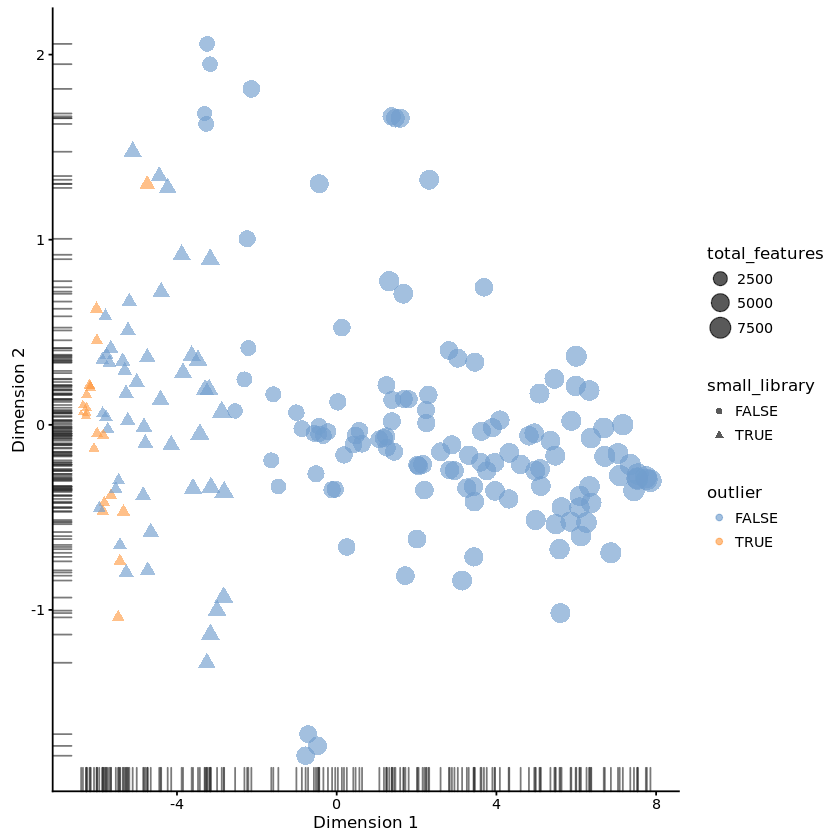

Perplexity =  50  , Seed =  501 


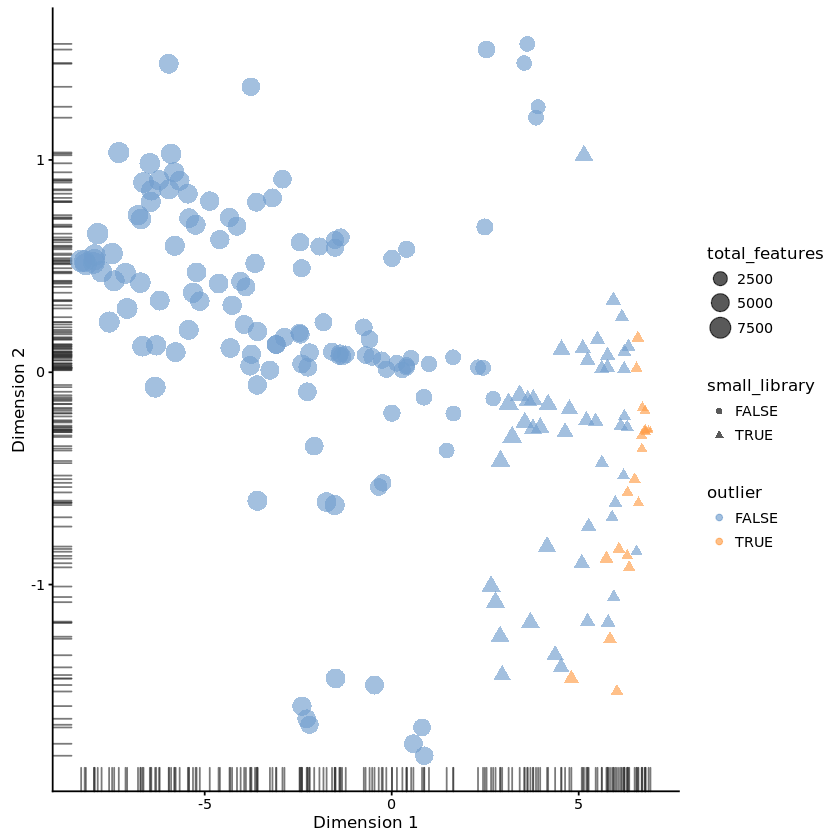

Perplexity =  50  , Seed =  222130 


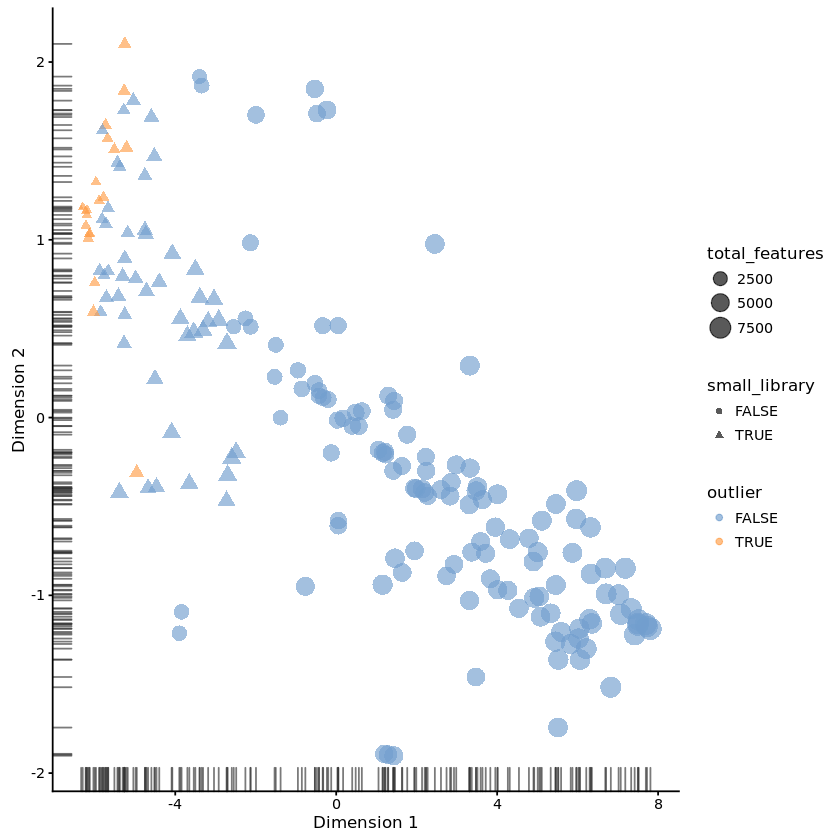

Perplexity =  60  , Seed =  1 


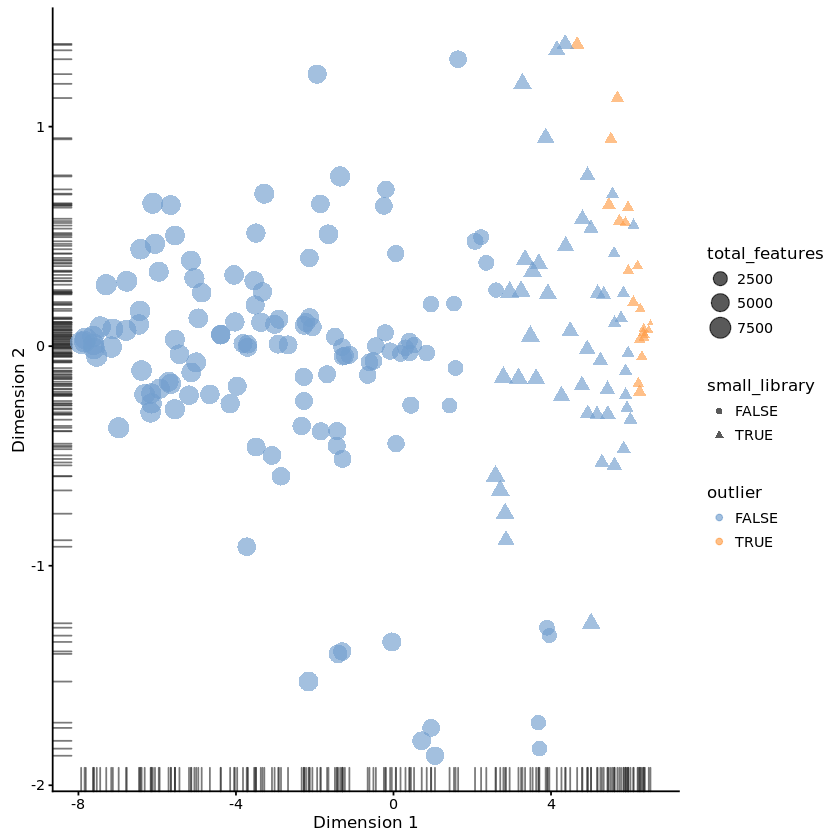

Perplexity =  60  , Seed =  12 


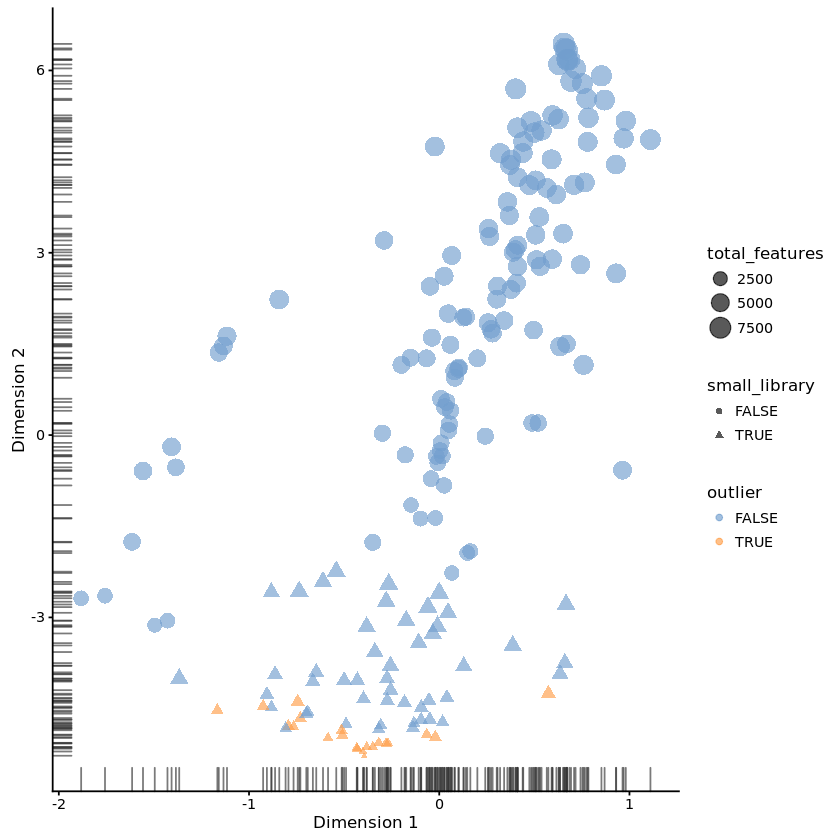

Perplexity =  60  , Seed =  501 


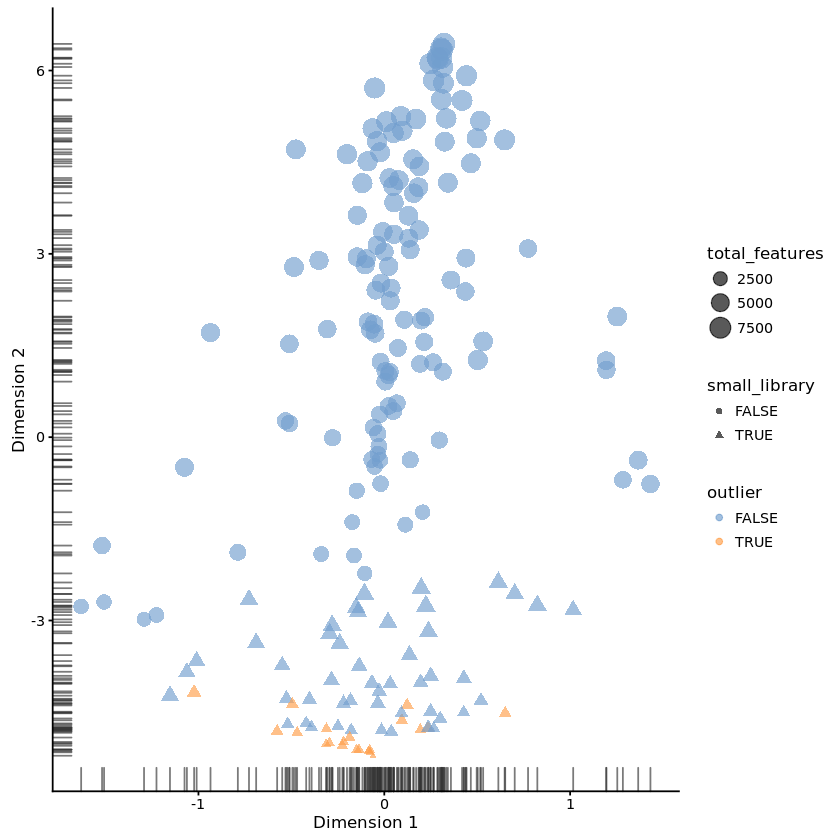

Perplexity =  60  , Seed =  222130 


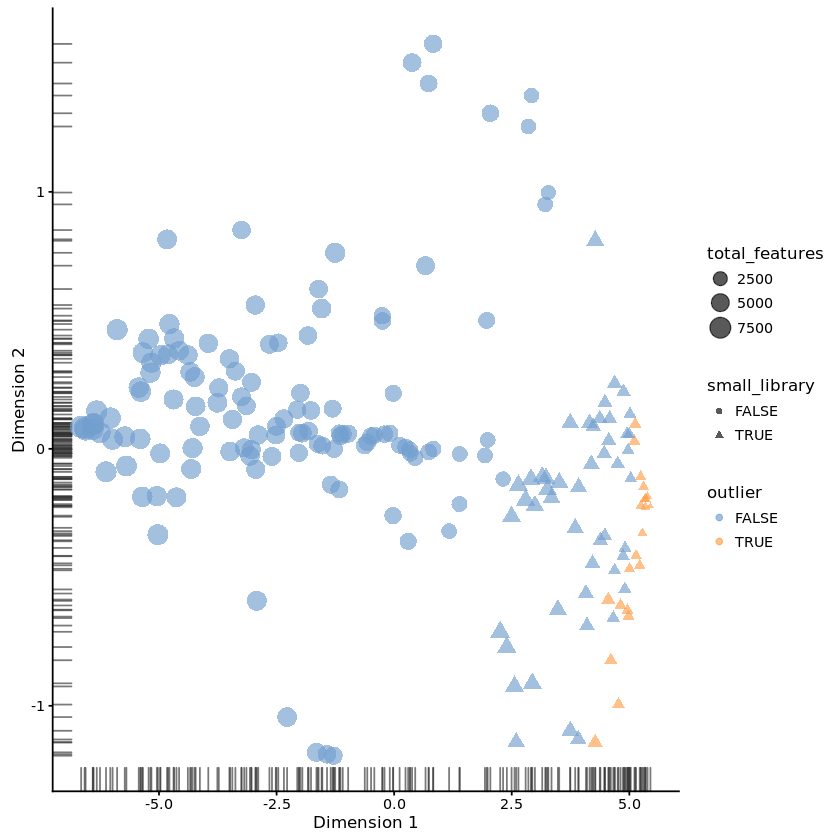

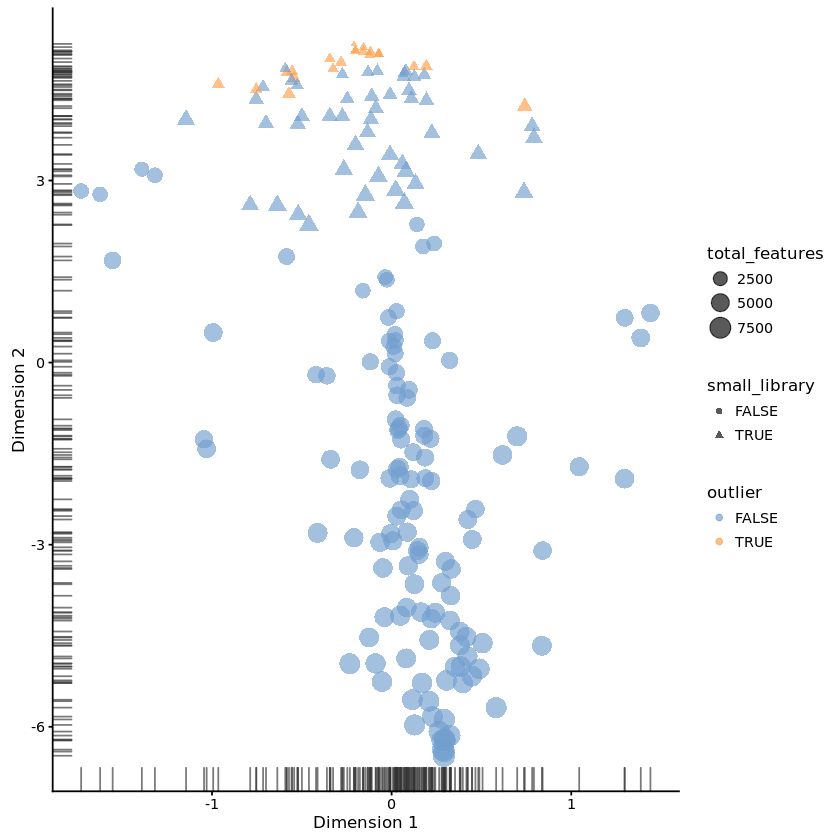

In [138]:
message("Let us see if TSNE plots cluster better.")
message("Note that TSNE clustering is also not affected by the filtering for any thresholds")


for (perp in list(1,2,3,4,5,10,20,30,40,50,60)){
    for (ran in list(1,12,501,222130)){
        cat("Perplexity = ", perp," , Seed = ", ran, "\n")
        print(plotTSNE(
            sce.thresh1,
            exprs_values = "counts",
            perplexity = perp,  # max 60
            size_by = "total_features",
            colour_by = "outlier",
            shape_by = "small_library",
            rand = ran
        ))
    }
}



[1] 192

In [184]:
library(data.table)
library(scran)

message("We do indeed seem to get some clustering!")
message("Let us now officially filter and normalise the data before trying any more plots")

sce.raw <- copy(sce.thresh2)
sce.cpm <- copy(sce.thresh2)
sce.sf <- copy(sce.thresh2)
sce.tmm <- copy(sce.thresh2)
sce.scran <- copy(sce.thresh2)
sce.downs <- copy(sce.thresh2)

logcounts(sce.raw) <- log2(counts(sce.raw) + 1)
logcounts(sce.cpm) <- log2(calculateCPM(sce.cpm, use.size.factors = FALSE) + 1)
sce.sf  <- normaliseExprs(sce.sf, method = "RLE", return_log = TRUE, return_norm_as_exprs = TRUE)
sce.tmm <- normaliseExprs(sce.tmm, method = "TMM", return_log = TRUE, return_norm_as_exprs = TRUE)

# scran CPM norm
qclust <- quickCluster(sce.scran, min.size = 2)
sce.scran <- computeSumFactors(sce.scran, sizes = 15, clusters = qclust)
sce.scran <- normalize(sce.scran)

# downsampling doesn't make sense for data which has low-seq coverage


We do indeed seem to get some clustering!
Let us now officially filter and normalise the data before trying any more plots


A comparison of the various normalisation method


,AGTGTC,ACCATG,GAGTGA,CACTCA,CATGTC,ACAGGA,GTACCA,ACAGAC,ACGTTG
RAW,0,2.000000,1.584963,1.584963,2.584963,3.000000,2.807355,1.584963,0
CPM,0,1.458578,1.602025,2.074930,2.152851,2.134945,2.367590,2.253951,0
SF,0,1.501720,1.559597,1.450738,2.045065,2.500167,2.408578,1.364187,0
TMM,0,1.521334,1.524549,1.926083,2.253289,2.273259,2.384335,2.029929,0
SCRAN,0,1.417747,1.641247,2.095392,2.165168,2.076158,2.435822,2.282787,0


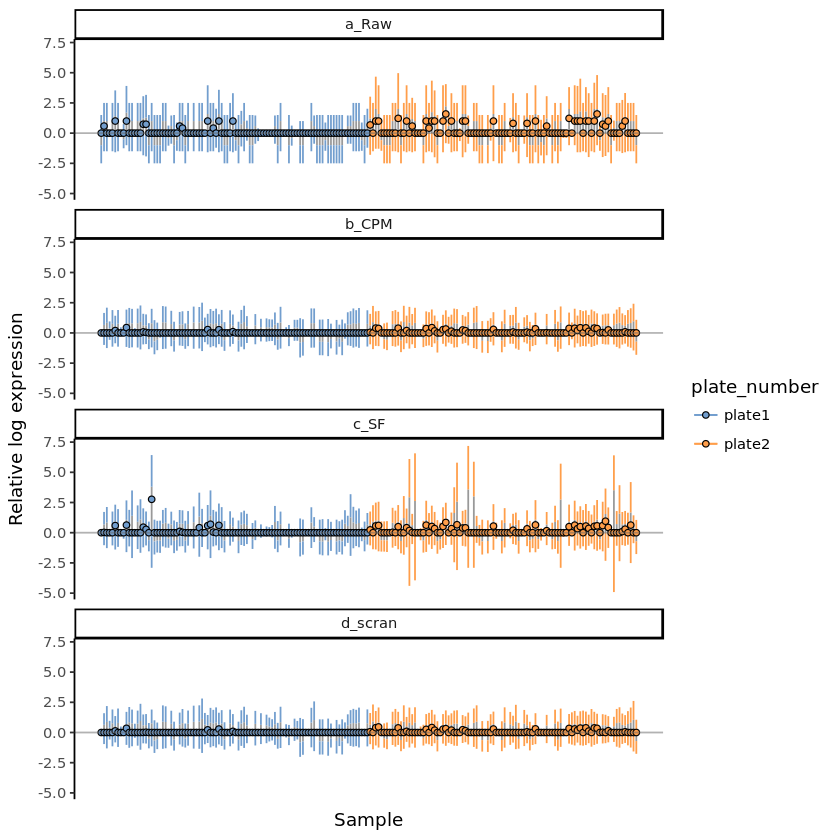

In [192]:
message("A comparison of the various normalisation method")

tableau <- rbind(
    head(logcounts(sce.raw), 1),
    head(logcounts(sce.cpm), 1),
    head(logcounts(sce.sf), 1),
    head(logcounts(sce.tmm), 1),
    head(logcounts(sce.scran), 1)
)
rownames(tableau) <- c("RAW", "CPM", "SF", "TMM", "SCRAN")
tableau[,1:9]

plotRLE(
    sce.thresh2,  # not used
    exprs_mats = list(
        a_Raw   = logcounts(sce.raw),
        b_CPM   = logcounts(sce.cpm),
        c_SF    = logcounts(sce.sf),
        d_scran = logcounts(sce.scran)
    ),
    exprs_logged = c(TRUE, TRUE, TRUE, TRUE),
    colour_by = "plate_number",
    order_by_color = FALSE
)


The variable is_cell_control only has one unique value, so R^2 is not meaningful.
This variable will not be plotted.
Warning message in self$trans$transform(x):
“NaNs produced”Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Removed 21 rows containing non-finite values (stat_density).”

ERROR: Error in assay(object, exprs_values): 'assay(<SingleCellExperiment>, i="character", ...)' invalid subscript 'i'
'i' not in names(assays(<SingleCellExperiment>))


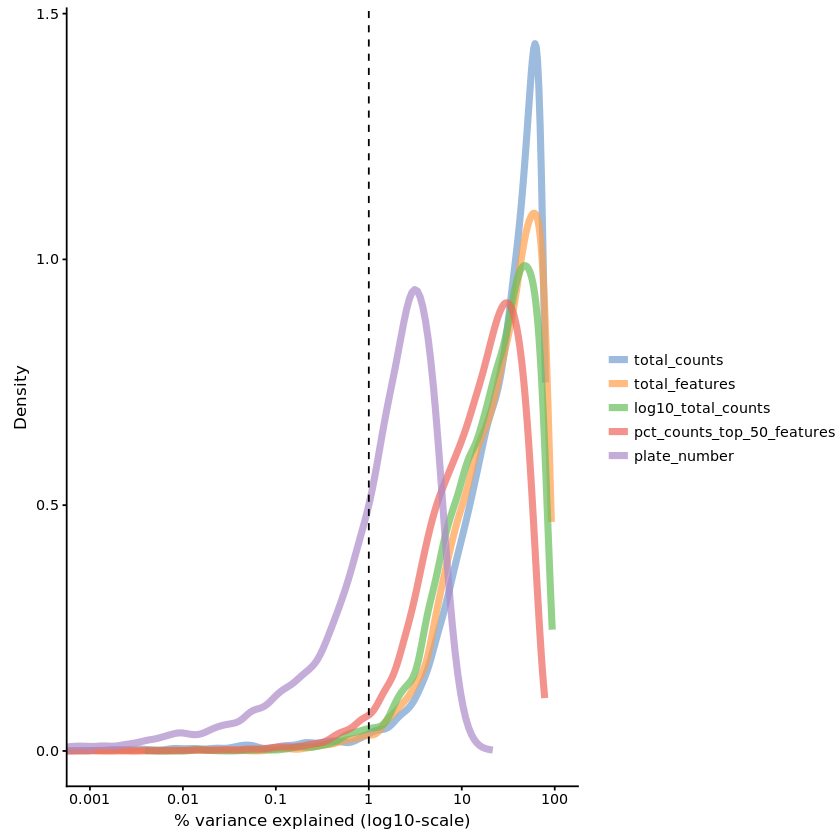

In [148]:
plotQC(
    sce.thresh2,
    type = "expl",
    exprs_values = "logcounts_raw",
    variables = c(
        "plate_number",
        "total_features",
        "total_counts",
        "log10_total_counts",
        "pct_counts_top_50_features",
        "is_cell_control"
    )
)

plotQC(
    sce.thresh2,
    type = "expl",
    exprs_values = "logcounts",
    variables = c(
        "plate_number",
        "total_features",
        "total_counts",
        "log10_total_counts",
        "pct_counts_top_50_features",
        "is_cell_control"
    )
)